# Modelling Most-Active US Stocks

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.stats

from itertools import combinations
from scipy.linalg import solve_triangular
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.correlation_tools import cov_nearest
from scipy.stats import norm, gaussian_kde
from sklearn.metrics import mean_squared_error, r2_score
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson, jarque_bera

In [2]:
# Test whether cuda and gpu is available
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2.3.0
False


In [3]:
# For easy use involving just all raw tickers
tickers = [
    'NVDA', 'TSLA', 'INTC', 'LCID', 'SOFI', 'F', 'PLTR', 'AAL', 'MRVL', 'QBTS',
    'RIOT', 'AMD', 'PCG', 'OSCR', 'WBD', 'AAPL', 'AMZN', 'QUBT', 'HIMS', 'SMCI',
    'BAC', 'PFE', 'MARA', 'COIN', 'ACHR', 'HOOD', 'GOOG', 'CLF', 'AVGO', 'RGTI',
    'GOOGL', 'APLD', 'HL', 'T', 'SNAP', 'AUR', 'CLSK', 'UBER', 'HBAN', 'WFC',
    'SOUN', 'GNW', 'AGNC', 'MRK', 'CSCO', 'ASTS', 'PYPL', 'JOBY', 'MU', 'CCL',
    'MP', 'VZ', 'RKLB', 'IONQ', 'LYFT', 'XOM', 'MSFT', 'SLB', 'AES', 'QXO',
    'ADT', 'CMCSA', 'RIVN', 'KO', 'HAL', 'BMY', 'PTEN', 'OXY', 'PTON', 'ORCL',
    'V', 'OKLO', 'C', 'ENPH', 'NKE'
]

In [4]:
# Fetch daily closing prices
data = yf.download(
    tickers=tickers,
    start='2015-01-01',
    end='2025-01-01',
    interval='1d',
    group_by='ticker'
)

# Create clean DataFrame
closing_prices = pd.DataFrame({
    t: data[t]['Close'] for t in tickers
}).dropna()

C:\Users\Brian\AppData\Local\Temp\ipykernel_3360\2411876538.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  75 of 75 completed


In [5]:
# Calculate the daily log returns (trade working days)
log_returns = np.log(closing_prices).diff().dropna()
log_returns

,NVDA,TSLA,INTC,LCID,SOFI,F,PLTR,AAL,MRVL,QBTS,...,BMY,PTEN,OXY,PTON,ORCL,V,OKLO,C,ENPH,NKE
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-29,-0.064464,-0.007722,-0.071910,-0.043826,-0.052518,-0.031969,-0.051534,-0.034558,-0.050036,0.000000,...,-0.025318,-0.059049,-0.034609,-0.050524,-0.036650,-0.034721,0.000000,-0.026608,-0.018842,-0.018670
2022-05-02,0.051797,0.036290,0.030945,0.052786,0.033738,0.007738,0.032169,-0.011251,0.033689,0.001011,...,-0.002527,-0.012240,0.056634,0.064503,0.008141,-0.007536,0.000000,0.010318,0.042041,0.011006
2022-05-03,0.003526,0.006964,0.002222,0.027938,0.010998,0.020119,-0.017849,0.030249,0.005644,-0.001011,...,-0.000400,0.040428,0.015995,-0.022679,-0.009641,-0.014140,0.000000,0.028137,0.036170,-0.025871
2022-05-04,0.036663,0.046596,0.032317,0.033119,0.109415,0.028438,0.039950,0.025292,0.040550,0.000000,...,0.016649,0.038288,0.038578,0.021611,0.025860,0.028176,0.003075,0.041636,0.095086,0.025712
2022-05-05,-0.076100,-0.086960,-0.034705,-0.072136,-0.044388,-0.030500,-0.081562,-0.056619,-0.076274,0.000000,...,-0.000787,-0.078716,0.011626,-0.095257,-0.032568,-0.044223,-0.002049,-0.017771,-0.057913,-0.060749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.003930,0.070991,0.009852,0.031749,0.024646,0.012048,0.020728,0.005780,0.019068,-0.024846,...,0.003121,0.021053,0.005836,0.009662,0.013332,0.010755,0.069719,0.017476,0.003828,0.000391
2024-12-26,-0.002070,-0.017787,0.001959,0.030772,0.035565,0.004978,-0.002918,0.000000,-0.002072,0.219363,...,0.004147,0.018065,0.001661,0.092782,0.001574,0.000811,0.018049,0.004917,-0.003691,0.001952
2024-12-27,-0.021088,-0.050745,-0.006873,-0.030772,-0.038065,-0.003980,-0.037965,0.000000,-0.018227,0.001010,...,-0.005533,0.003829,0.007441,-0.089582,-0.015970,-0.007036,-0.053836,-0.004917,-0.012126,-0.006782


Step 1: check for (first-order) stationarity/near-stationarity for log-return series.

In [6]:
adf_statistic_list = []

for ticker in tickers:
    adf_statistic_list.append(adfuller(log_returns[ticker].to_numpy())[1])
    
if all(x < 0.05 for x in adf_statistic_list):
    print('All log-return series are (near) stationary, via ADF test.')
else:
    print('Exist non-stationary return series.')

All log-return series are (near) stationary, via ADF test.


Step 2: compute the $R^2$ and $d$ for pairwise stock's log-return.

In [7]:
results = []

for i, stock_i in enumerate(tickers):
    for stock_j in tickers[i+1:]:
        y = log_returns[stock_i].dropna()
        x = log_returns[stock_j].reindex(y.index).dropna()
        y = y.reindex(x.index)
        
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        
        results.append({
            'dependent_stock': stock_i,
            'regressor_stock': stock_j,
            'R2': model.rsquared,
            'DW': durbin_watson(model.resid)
        })

df_stats = pd.DataFrame(results)  # have length 2775 = 75 * (75-1)/2

# Add a new column for checking spurious regression via R^2 > d
df_stats['spurious'] = df_stats['R2'] > df_stats['DW']
df_stats.head()

,dependent_stock,regressor_stock,R2,DW,spurious
0,NVDA,TSLA,0.188986,2.007030,False
1,NVDA,INTC,0.159596,2.060476,False
2,NVDA,LCID,0.069470,2.048850,False
3,NVDA,SOFI,0.098468,2.086680,False
4,NVDA,F,0.129623,2.091349,False


In [8]:
# 1) Check if there is at least one True in the column
spurious_reg = df_stats['spurious'].any()
print('Do we have any spurious regressions?', spurious_reg)

# 2) If so, count how many
num_spur = df_stats['spurious'].sum()
print(f'Number of spurious pairs: {num_spur} out of {len(df_stats)}')

Do we have any spurious regressions? False
Number of spurious pairs: 0 out of 2775


Therefore, throughout above evaluation, we can see that there is negligible spurious regression for our log-return series. This means we could then use correlation-based methods for constructing our virtual network.

---

We would need to set a 'window', under the assumption that the **log-return for each stock within one month can be seen as iid samples drawn from an identical distribution.** As our interval is set to be 1 day for high-frequency data, we may first illustrate how many data for each month.

In [9]:
for (year, month), df_group in log_returns.groupby([log_returns.index.year,
                                                   log_returns.index.month]):
    print(f'On year {year}, month {month}, there are total {len(df_group)} recorded intraday high-frequency log-return data.')

On year 2022, month 4, there are total 1 recorded intraday high-frequency log-return data.
On year 2022, month 5, there are total 21 recorded intraday high-frequency log-return data.
On year 2022, month 6, there are total 21 recorded intraday high-frequency log-return data.
On year 2022, month 7, there are total 20 recorded intraday high-frequency log-return data.
On year 2022, month 8, there are total 23 recorded intraday high-frequency log-return data.
On year 2022, month 9, there are total 21 recorded intraday high-frequency log-return data.
On year 2022, month 10, there are total 21 recorded intraday high-frequency log-return data.
On year 2022, month 11, there are total 21 recorded intraday high-frequency log-return data.
On year 2022, month 12, there are total 21 recorded intraday high-frequency log-return data.
On year 2023, month 1, there are total 20 recorded intraday high-frequency log-return data.
On year 2023, month 2, there are total 19 recorded intraday high-frequency log

As we assume the distribution on a single day can be invariant, we would compute correlation matrix at each day therefore. The strategy would be:

1. Compute CoC matrix along with different trading days - so if we have total 5 different trading days, we would first have 5 daily correlation matrix where every entry is taken their absolute correlation value. Absolute values are appropriate as they focus on connection strength but not the direction, **because we would assume two stocks are closely related/'similar' if they have large correlation values despite of the sign (whether changing in the same direction or opposite direction).** 

2. Then we would do sum-and-average to obtain an averaged CoC matrix over the trading time interval. This averaged correlation matrix would be used for our construction of network.

In [10]:
def average_corr_computation(df, quantile_val):
    """
    Compute the average daily correlation matrix (one correlation matrix per calendar day), 
    and the threshold at the given quantile of off-diagonal absolute average CoC values.
    
    Args:
        df (pd.DataFrame): the pd.DataFrame contains the time series data of shape (T,d), T for time steps and d for number of nodes.
        quantile_val (float): a float between 0 and 1 for determining the threshold based on quantiles.
    
    Returns:
        average_coc_mat (np.ndarray): the averaged CoC matrix by taking the average of the sum of CoC matrix for each trading day.
        threshold (float): the threshold value for building the edge between nodes.
    """
    
    df = df.sort_index()  # make sure our df is sorted by time
    
    # Group by calendar month
    months = df.index.to_period('M')
    grouped = df.groupby(months)
    d = df.shape[1]  # number of nodes/stocks
    total_corr_mat = np.zeros((d, d))  # initialise the total corr matrix
    valid_months = 0  # Count of months with valid data
    
    for month, month_data in grouped:
        # Skip months with insufficient data, we need at least two observations for each month
        if len(month_data) < 2:
            continue
            
        # Check for constant columns (zero variance)
        std_devs = month_data.std()
        if (std_devs == 0).any():
            continue
            
        # Compute correlation matrix
        corr_mat = np.corrcoef(month_data.values, rowvar=False)
        corr_mat = abs(corr_mat)  # take the absolute value of corr values showing how close but no sign-direction
        total_corr_mat += corr_mat
        valid_months += 1  # update valid months count
    
    # Handle case with no valid months
    if valid_months == 0:
        average_corr_mat = np.full((d, d), np.nan)  # give a NaN matrix if no valid months
        threshold = np.nan  # no threshold if no valid months
    else:
        # Since averaging would not change the quantile, it is absolutely fine if we just keep total_coc_mat
        # but statistically speaking we may still prefer using the averaged one over all trading days
        average_corr_mat = total_corr_mat / valid_months
        # Extract off-diagonal upper triangle CoC values (as absolute values)
        off_diag_vals = average_corr_mat[np.triu_indices(d, k=1)]
        threshold = np.quantile(off_diag_vals, quantile_val)  # set the threshold to be chosen quantile
    
    return average_corr_mat, threshold

In [11]:
average_corr_computation(log_returns, quantile_val=0.7)

(array([[1.        , 0.40887924, 0.45443631, ..., 0.34049913, 0.30645613,
         0.35611633],
        [0.40887924, 1.        , 0.32279472, ..., 0.37100328, 0.3941101 ,
         0.33779076],
        [0.45443631, 0.32279472, 1.        , ..., 0.38481522, 0.30899086,
         0.3702957 ],
        ...,
        [0.34049913, 0.37100328, 0.38481522, ..., 1.        , 0.34739139,
         0.3798013 ],
        [0.30645613, 0.3941101 , 0.30899086, ..., 0.34739139, 1.        ,
         0.31253781],
        [0.35611633, 0.33779076, 0.3702957 , ..., 0.3798013 , 0.31253781,
         1.        ]]),
 0.3535413134567713)

In [12]:
def coc_network_construction(df, quantile_val):
    """Return the network constructed by CoC.

    Args:
        df (pd.DataFrame): the pd.DataFrame contains the time series data of shape (T,d), T for time steps and d for number of nodes.
        quantile_val (float): a float between 0 and 1 for determining the threshold based on quantiles.
    """
    # First compute the average_coc_mat and threshold via defined function above
    average_corr_mat, threshold = average_corr_computation(df, quantile_val)
    
    # 1) Initialise an empty undirected graph
    G = nx.Graph()
    labels = df.columns.tolist()

    # 2) Add all tickers as nodes
    G.add_nodes_from(labels)

    # 3) Add an (unweighted) edge whenever |CoC| > threshold
    d = average_corr_mat.shape[0]
    for i, j in combinations(range(d), 2):
        if abs(average_corr_mat[i, j]) > threshold:
            G.add_edge(labels[i], labels[j])

    # 4) Visualise with a spring‐layout
    pos = nx.spring_layout(G, k=1.5, seed=0)
    plt.figure(figsize=(16, 10))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='orange', edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='blue', font_weight='bold')
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(
        f'Unweighted GNGARCH correlation Network\n(|corr| > {threshold:.4f}, {quantile_val*100:.0f}% quantile)',
        fontsize=20
    )
    plt.axis("off")
    
    # 5) Compute the store the adjacency matrix for this network
    A = nx.to_numpy_array(G, nodelist=labels, dtype=int)
    
    return A, G

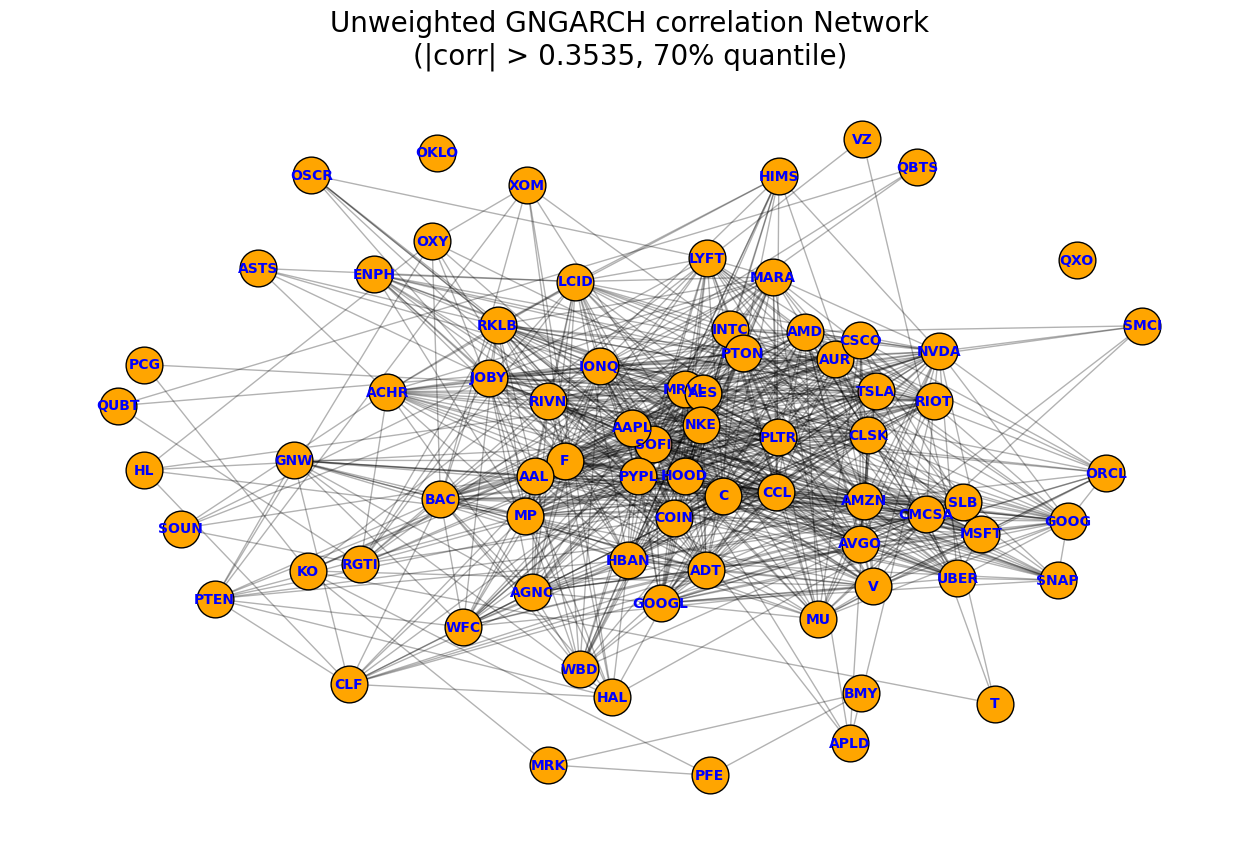

In [13]:
A, G = coc_network_construction(log_returns, quantile_val=0.7)

In [14]:
def r_stage_node_weight_matrix(G, r):
    """
    Compute the r-stage neighbourhood node weight matrix W^(r) for a network G.
    See the definition of r-stage node weight matrix in the paper.

    Args:
        G (nx.Graph): An unweighted undirected graph.
        r (int): The neighbourhood order (distance) to consider.

    Returns:
        W (np.ndarray): The row-normalized weight matrix for r-stage neighbours. Nodes are ordered according to G.nodes().
    """
    
    nodes = sorted(list(G.nodes()))  # correct ascending order
    d = len(nodes)
    idx = {node: i for i, node in enumerate(nodes)}
    W = np.zeros((d, d), dtype=float)

    # Precompute all shortest‐path lengths up to distance r
    spl = dict(nx.all_pairs_shortest_path_length(G, cutoff=r))

    for i, u in enumerate(nodes):
        # Find r‐stage neighbours
        neigh_r = [v for v, d in spl.get(u, {}).items() if d == r]
        if not neigh_r:
            # if no r‐neighbours, skip (all zeros in that row)
            continue
        # Fetch tilde‐weights
        tilde = []
        for v in neigh_r:
            data = G.get_edge_data(u, v) or {}
            tilde_w = data.get('weight', 1.0)
            tilde.append(tilde_w)

        tilde = np.array(tilde, dtype=float)
        total = tilde.sum()
        if total == 0:
            # Equal weights (unweighted network)
            weights = np.ones_like(tilde) / len(tilde)
        else:
            # Weighted network
            weights = tilde / total

        # Fill row i in W
        for v, w in zip(neigh_r, weights):
            j = idx[v]
            W[i, j] = w

    return W

In [15]:
def node_weight_matrix(G):
    """Generate the total node weight matrix W, as the sum of all non-zero r-stage node weight matrices.

    Args:
        G (nx.Graph): An unweighted undirected graph.
    Returns:
        W_total (np.ndarray): The overall node weight matrix for the network G. 
    """
    
    nodes = list(G.nodes())
    d = len(nodes)
    # Initialise the total node weight matrix W_total
    W_total = np.zeros((d, d), dtype=float)
    
    # Initialise r=1 for the first stage node weight matrix
    r = 1
    
    while True:
        W_r = r_stage_node_weight_matrix(G, r)
        # If W_r has no non-zero entries (all entries are zero), break
        # this can be done by using np.any OR logic gate
        if not np.any(W_r):
            break
        # Otherwise accumulate and move to next r
        W_total += W_r
        r += 1

    return W_total

---

Let's apply a quick check for the validity of the above functions.

In [16]:
W_tot = np.zeros((len(tickers), len(tickers)))

for r in range(1, 7):
    print(f'Is the {r}-stage node weight matrix a zero matrix?', np.all(r_stage_node_weight_matrix(G, r) == np.zeros((len(tickers), len(tickers)))))
    W_tot += r_stage_node_weight_matrix(G, r)
    
W_total = node_weight_matrix(G)

# Since we already achieve zero matrix for r > 6, then we expect W_tot == W_total to show our function is valid
np.all(W_tot == W_total)

Is the 1-stage node weight matrix a zero matrix? False
Is the 2-stage node weight matrix a zero matrix? False
Is the 3-stage node weight matrix a zero matrix? False
Is the 4-stage node weight matrix a zero matrix? False
Is the 5-stage node weight matrix a zero matrix? False
Is the 6-stage node weight matrix a zero matrix? True


True

---

Now we have our constructed virtual network $G$, adjacency matrix $\mathbf{A}$ and node weight matrix $\mathbf{W}$. We may now be able to fit our GNGARCH model.

Before that, we may center the log-return series, where we first find the sample mean of every stock's log-return.

In [17]:
# We may first write out the sample mean log-return
# it is close to 0 as expected
log_returns.mean().to_numpy()

array([ 2.85226285e-03,  4.79974274e-04, -1.16190254e-03, -2.72823783e-03,
        1.29507051e-03, -3.00651812e-04,  2.87576422e-03, -1.61644944e-04,
        8.98999875e-04, -2.42994821e-04, -1.02765064e-04,  4.43827182e-04,
        6.67609776e-04,  8.21181021e-04, -8.20847953e-04,  6.55424641e-04,
        6.20392685e-04,  3.51443493e-03,  2.53221905e-03,  2.91506094e-03,
        3.73828860e-04, -7.67565808e-04, -7.96485959e-06,  1.04907267e-03,
        1.10819999e-03,  1.94401112e-03,  6.99923146e-04, -1.59418478e-03,
        2.15510855e-03,  1.21603445e-03,  7.02156014e-04,  1.19172218e-03,
       -1.08133141e-04,  4.68863776e-04, -1.46422321e-03,  5.10656699e-04,
        3.99823943e-04,  9.05692920e-04,  4.67955610e-04,  7.69524031e-04,
        1.44761472e-03,  9.03052603e-04,  2.55203211e-04,  2.87737405e-04,
        3.52392406e-04,  1.46192007e-03, -1.13104001e-04,  6.25498893e-04,
        2.96368550e-04,  4.98196829e-04, -1.40120315e-03, -3.90917230e-05,
        1.81735977e-03,  

In [18]:
# Center the log-returns
log_returns -= log_returns.mean()
log_returns_data = log_returns.to_numpy()
log_returns.head()

,NVDA,TSLA,INTC,LCID,SOFI,F,PLTR,AAL,MRVL,QBTS,...,BMY,PTEN,OXY,PTON,ORCL,V,OKLO,C,ENPH,NKE
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-29,-0.067317,-0.008202,-0.070748,-0.041098,-0.053813,-0.031669,-0.054409,-0.034397,-0.050935,0.000243,...,-0.025002,-0.058038,-0.034446,-0.049404,-0.037870,-0.035287,-0.001159,-0.027285,-0.017543,-0.017956
2022-05-02,0.048945,0.035810,0.032107,0.055514,0.032443,0.008039,0.029294,-0.011090,0.032790,0.001254,...,-0.002212,-0.011229,0.056797,0.065623,0.006921,-0.008102,-0.001159,0.009641,0.043340,0.011720
2022-05-03,0.000674,0.006484,0.003384,0.030666,0.009703,0.020419,-0.020725,0.030411,0.004745,-0.000768,...,-0.000084,0.041439,0.016158,-0.021559,-0.010861,-0.014706,-0.001159,0.027460,0.037470,-0.025157
2022-05-04,0.033810,0.046116,0.033479,0.035847,0.108120,0.028739,0.037074,0.025453,0.039651,0.000243,...,0.016965,0.039299,0.038741,0.022731,0.024640,0.027610,0.001916,0.040959,0.096386,0.026427
2022-05-05,-0.078952,-0.087440,-0.033543,-0.069407,-0.045683,-0.030200,-0.084438,-0.056457,-0.077173,0.000243,...,-0.000471,-0.077704,0.011789,-0.094136,-0.033789,-0.044789,-0.003209,-0.018448,-0.056613,-0.060034


In [19]:
class GNGARCH(nn.Module):
    def __init__(self, d, W, S, device, init_params=None):
        super().__init__()
        self.d = d
        self.device = device
        
        # Compute W_s and create neighbour mask
        W_s = W * S
        self.register_buffer('W_s', W_s)
        
        # Initialize trainable log-parameters
        if init_params is None:
            init_vals = torch.tensor([0.1, 0.3, 0.4, 0.1, 0.1], 
                                    dtype=torch.float32, device=device)
            init_params = torch.log(init_vals)
        self.params = nn.Parameter(init_params)

    def get_params(self):
        """Return constrained (positive) parameters"""
        alpha0, alpha1, gamma1, beta11, delta11 = torch.exp(self.params)
        return alpha0, alpha1, gamma1, beta11, delta11
    
    @staticmethod
    def compute_B_t(X_t):
        """Compute and return matrix B_t, PyTorch version."""
        B_t = torch.outer(X_t, X_t)
        B_t.fill_diagonal_(0.0)  # we can directly use fill_diagonal_ in PyTorch when it is just a number
        return B_t
    
    @staticmethod
    def compute_D_t(cov_t):
        """Compute and return matrix D_t, PyTorch version."""
        D_t = cov_t.clone()
        D_t.fill_diagonal_(0.0)
        return D_t

    def ensure_posdef(self, cov_mat):
        """
        Ensure covariance matrix is positive definite and not ill-conditioned by adding jitter, 
        so we can use Cholesky decomposition.
        """
        # Compute the eigenvalues and check if the matrix is positive definite
        min_eigval = torch.min(torch.linalg.eigvalsh(cov_mat))
        jitter = torch.zeros_like(cov_mat)  # initialise jitter to zero
        # Set a threshold for jitter, ensuring PD and not ill-conditioned 
        # this value is normally 1e-3 or 1e-4, as even smaller thresholds may lead slow convergence (still ill-conditioned)
        # a big threshold may perturb the covariance matrix too much
        threshold = 1e-3
        # If the minimum eigenvalue is less than threshold, we need to add jitter to ensure PD
        if min_eigval < threshold:
            jitter = (-min_eigval + threshold) * torch.eye(self.d, device=self.device)
        
        cov_mat += jitter  # Add jitter to the covariance matrix
        return cov_mat

    def compute_conditional(self, X_prev, var_prev, cov_prev):
        """Vectorised computation with proper exclusions"""
        alpha0, alpha1, gamma1, beta11, delta11 = self.get_params()
        d = self.d
        
        # 1. Vectorised variance update
        clustering_term = beta11 * (self.W_s @ (X_prev ** 2))
        persistence_term = delta11 * (self.W_s @ var_prev)
        var_curr = alpha0 + alpha1 * (X_prev ** 2) + gamma1 * var_prev + clustering_term + persistence_term
        
        # 2. Vectorised covariance update
        # Base GARCH component
        base_cov = alpha0 + alpha1 * torch.outer(X_prev, X_prev) + gamma1 * cov_prev
        
        # Neighbouring clustering effect using vectorisation
        compute_B_prev = self.compute_B_t(X_prev)
        clustering_i_neighbour = self.W_s @ compute_B_prev
        clustering_j_neighbour = compute_B_prev @ self.W_s.T
        clustering_neighbour = 0.5 * beta11 * (clustering_i_neighbour + clustering_j_neighbour)
        
        # Neighbouring persistence effect using vectorisation
        compute_D_prev = self.compute_D_t(cov_prev)
        persistence_i_neighbour = self.W_s @ compute_D_prev
        persistence_j_neighbour = compute_D_prev @ self.W_s.T
        persistence_neighbour = 0.5 * delta11 * (persistence_i_neighbour + persistence_j_neighbour)
        
        # Combine components, both based part and neighbouring part
        cov_curr = base_cov + clustering_neighbour + persistence_neighbour
        cov_curr[range(d), range(d)] = var_curr  # Set diagonal
        cov_curr = self.ensure_posdef(cov_curr)  # Ensure positive definiteness
        
        return var_curr, cov_curr
    
    def nll_loss(self, X_data, var0, cov0):
        """
        Compute the negative Log-Likelihood loss, which is proportional to QLIKE (invariant to a constant),
        assumes conditional multivariate normal distribution (needed for QLIKE).
        """
        
        T, d = X_data.shape
        total_nll = 0.0

        var_prev, cov_prev = var0.clone(), cov0.clone()
        const = d * torch.log(2 * torch.tensor(torch.pi, device=self.device))

        for t in range(1, T):
            X_prev, X_curr = X_data[t-1], X_data[t]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            L = torch.linalg.cholesky(cov_curr)

            # Compute the log-determinant term using Cholesky decomposition L
            log_det = 2.0 * torch.sum(torch.log(torch.diag(L)))
            
            # Compute the quadratic form: X_curr^T * inv(Sigma) * X_curr
            inv_cov_curr = torch.cholesky_inverse(L)
            quad = X_curr @ (inv_cov_curr @ X_curr)
            total_nll += 0.5 * (const + log_det + quad)
            
            # Update previous values for next iteration
            var_prev, cov_prev = var_curr, cov_curr

        return total_nll / (T - 1)
    
    # An alternative loss function that computes the MSE
    def mse_loss(self, X_data, var0, cov0):
        """
        Vectorized MSE loss computation, comparing conditional covariance with observed squared returns.
        """
        
        T, d = X_data.shape
        total_mse = 0.0
        var_prev = var0.clone()
        cov_prev = cov0.clone()
        
        for t in range(1, T):
            X_prev = X_data[t-1]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            # Compute observed covariance proxy (squared returns)
            obs_cov = torch.outer(X_data[t], X_data[t])
            # Vectorised MSE
            total_mse += torch.mean((cov_curr - obs_cov) ** 2)
            
            # Update state
            var_prev = var_curr
            cov_prev = cov_curr
        return total_mse / (T - 1)
    
    def forward(self, X_data, var0, cov0):
        T, d = X_data.shape
        X_sim = torch.zeros_like(X_data)
        var_prev = var0.clone()
        cov_prev = cov0.clone()
        X_sim[0] = X_data[0]
        
        for t in range(1, T):
            X_prev = X_data[t-1]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            L = self.ensure_posdef_cholesky(cov_curr)
            
            Z = torch.randn(d, device=self.device)
            X_sim[t] = L @ Z
            # Update the previous values for the next iteration
            var_prev = var_curr
            cov_prev = cov_curr
        return X_sim

In [20]:
def train(n_epochs, model, data, var0, cov0, method, optimizer):
    loss_history = []
    for epoch in range(1, n_epochs+1):
        optimizer.zero_grad()
        if method in ('nll', 'qlike'):
            loss = model.nll_loss(data, var0, cov0)
        elif method == 'mse':
            loss = model.mse_loss(data, var0, cov0)
        else:
            raise ValueError('Method must be either nll/qlike or mse.')
        # Store the loss for plotting
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}: {method} loss = {loss.item():.4f}')
            
    # Extract fitted parameters
    with torch.no_grad():
        alpha0, alpha1, gamma1, beta11, delta11 = model.get_params()
    print(f'Fitted parameters via {method}:')
    print(f'alpha0 = {alpha0.item():.4f}')
    print(f'alpha1 = {alpha1.item():.4f}')
    print(f'gamma1 = {gamma1.item():.4f}')
    print(f'beta11 = {beta11.item():.4f}')
    print(f'delta11 = {delta11.item():.4f}')
    
    return loss_history

In [21]:
# Prepare the data & network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GNGARCH_data_torch = torch.tensor(log_returns_data, dtype=torch.float32).to(device)  # shape (T, d)
T, d = GNGARCH_data_torch.shape
W_torch = torch.tensor(W_total, dtype=torch.float32).to(device)  # shape (d, d)
S1_torch = torch.tensor(A, dtype=torch.float32).to(device)  # shape (d, d)

# Initial states
var0 = torch.ones(d, dtype=torch.float32).to(device)  # initial variances
cov0 = torch.eye(d, dtype=torch.float32).to(device)  # initial covariances (identity matrix)

# Instantiate model + optimizer
model = GNGARCH(d=d, W=W_torch, S=S1_torch, device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
# Train the model with different losses
mse_loss_history = train(n_epochs=500, model=model, data=GNGARCH_data_torch, var0=var0, cov0=cov0, 
                         method='mse', optimizer=optimizer)
nll_loss_history = train(n_epochs=500, model=model, data=GNGARCH_data_torch, var0=var0, cov0=cov0, 
                         method='nll', optimizer=optimizer)

Epoch 100: mse loss = 0.0059
Epoch 200: mse loss = 0.0028
Epoch 300: mse loss = 0.0017
Epoch 400: mse loss = 0.0012
Epoch 500: mse loss = 0.0009
Fitted parameters via mse:
alpha0 = 0.0232
alpha1 = 0.0702
gamma1 = 0.1693
beta11 = 0.0236
delta11 = 0.0432
Epoch 100: nll loss = -138.7685
Epoch 200: nll loss = -140.9423
Epoch 300: nll loss = -141.6786
Epoch 400: nll loss = -142.1602
Epoch 500: nll loss = -142.4836
Fitted parameters via nll:
alpha0 = 0.0005
alpha1 = 0.1648
gamma1 = 0.7072
beta11 = 0.0008
delta11 = 0.0039


**An interesting remark:** 

- No matter taking the training time interval from 2015 (so total 47 stocks) or from 2022 (total 75 stocks), the parameter fitting results by using MSE + square returns are very close. This is reasonable as severe noisy effect would dominate the parameter fitting and always give us the similar results based on the noise.

- However, the parameter fitting results by using QLIKE/NLL are different when we change the dataset. This again is sensible as QLIKE behaves as a loss function that is more robust to the noise effect, so produce different results.

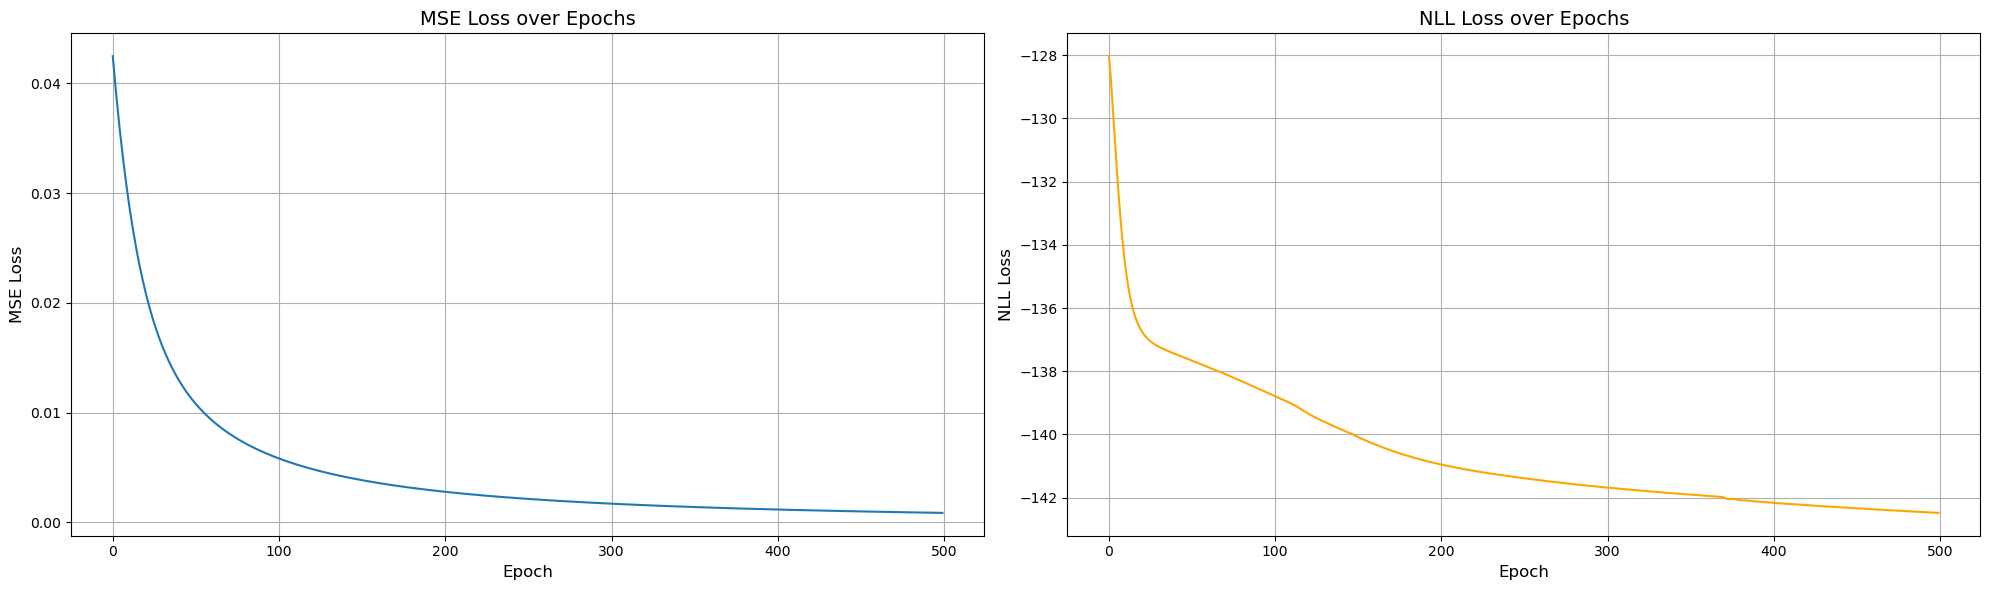

In [23]:
# Plot the training loss history for showing convergence

# Create 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# MSE loss convergence
axes[0].plot(mse_loss_history, label='MSE Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('MSE Loss over Epochs', fontsize=14)
axes[0].grid()

# NLL loss convergence
axes[1].plot(nll_loss_history, label='NLL Loss', color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('NLL Loss', fontsize=12)
axes[1].set_title('NLL Loss over Epochs', fontsize=14)
axes[1].grid()

plt.tight_layout()
plt.show()

A realisation for the current network GARCH by Zhou.

In [24]:
class network_GARCH_Zhou(nn.Module):
    def __init__(self, d, W, S, device, init_params=None):
        super().__init__()
        self.d = d
        self.device = device
        
        # Compute W_s and create neighbour mask
        W_s = W * S
        self.register_buffer('W_s', W_s)
        
        # Initialize trainable log-parameters
        if init_params is None:
            init_vals = torch.tensor([0.1, 0.3, 0.4, 0.1], 
                                    dtype=torch.float32, device=device)
            init_params = torch.log(init_vals)
        self.params = nn.Parameter(init_params)

    def get_params(self):
        """Return constrained (positive) parameters"""
        alpha0, alpha1, gamma1, beta11 = torch.exp(self.params)
        return alpha0, alpha1, gamma1, beta11

    def compute_conditional(self, X_prev, var_prev, cov_prev):
        """Vectorised computation with proper exclusions"""
        alpha0, alpha1, gamma1, beta11 = self.get_params()
        d = self.d
        
        # Vectorised variance update
        clustering_term = beta11 * (self.W_s @ (X_prev ** 2))
        var_curr = alpha0 + alpha1 * (X_prev ** 2) + gamma1 * var_prev + clustering_term
        
        # Vectorised covariance update (setting diagonal only)
        cov_curr = torch.zeros_like(cov_prev)  # initialisation
        cov_curr[range(d), range(d)] = var_curr  # Set diagonal
        
        return var_curr, cov_curr
    
    def nll_loss(self, X_data, var0, cov0):
        """
        Compute the negative Log-Likelihood loss, which is proportional to QLIKE (invariant to a constant),
        assumes conditional multivariate normal distribution (needed for QLIKE).
        """
        
        T, d = X_data.shape
        total_nll = 0.0

        var_prev, cov_prev = var0.clone(), cov0.clone()
        const = d * torch.log(2 * torch.tensor(torch.pi, device=self.device))

        for t in range(1, T):
            X_prev, X_curr = X_data[t-1], X_data[t]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            L = torch.linalg.cholesky(cov_curr)

            # Compute the log-determinant term using Cholesky decomposition L
            log_det = 2.0 * torch.sum(torch.log(torch.diag(L)))
            
            # Compute the quadratic form: X_curr^T * inv(Sigma) * X_curr
            inv_cov_curr = torch.cholesky_inverse(L)
            quad = X_curr @ (inv_cov_curr @ X_curr)
            total_nll += 0.5 * (const + log_det + quad)
            
            # Update previous values for next iteration
            var_prev, cov_prev = var_curr, cov_curr

        return total_nll / (T - 1)
    
    # An alternative loss function that computes the MSE
    def mse_loss(self, X_data, var0, cov0):
        """
        Vectorized MSE loss computation, comparing conditional covariance with observed squared returns.
        """
        
        T, d = X_data.shape
        total_mse = 0.0
        var_prev = var0.clone()
        cov_prev = cov0.clone()
        
        for t in range(1, T):
            X_prev = X_data[t-1]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            # Compute observed covariance proxy (squared returns)
            obs_cov = torch.outer(X_data[t], X_data[t])
            # Vectorized MSE
            total_mse += torch.mean((cov_curr - obs_cov) ** 2)
            
            # Update state
            var_prev = var_curr
            cov_prev = cov_curr
        return total_mse / (T - 1)
    
    def forward(self, X_data, var0, cov0):
        T, d = X_data.shape
        X_sim = torch.zeros_like(X_data)
        var_prev = var0.clone()
        cov_prev = cov0.clone()
        X_sim[0] = X_data[0]
        
        for t in range(1, T):
            X_prev = X_data[t-1]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            L = self.ensure_posdef_cholesky(cov_curr)
            
            Z = torch.randn(d, device=self.device)
            X_sim[t] = L @ Z
            # Update the previous values for the next iteration
            var_prev = var_curr
            cov_prev = cov_curr
        return X_sim

In [25]:
def train(n_epochs, model, data, var0, cov0, method, optimizer):
    loss_history = []
    for epoch in range(1, n_epochs+1):
        optimizer.zero_grad()
        if method in ('nll', 'qlike'):
            loss = model.nll_loss(data, var0, cov0)
        elif method == 'mse':
            loss = model.mse_loss(data, var0, cov0)
        else:
            raise ValueError('Method must be either nll/qlike or mse.')
        # Store the loss for plotting
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}: {method} loss = {loss.item():.4f}')
            
    # Extract fitted parameters
    with torch.no_grad():
        alpha0, alpha1, gamma1, beta11 = model.get_params()
    print(f'Fitted parameters via {method}:')
    print(f'alpha0 = {alpha0.item():.4f}')
    print(f'alpha1 = {alpha1.item():.4f}')
    print(f'gamma1 = {gamma1.item():.4f}')
    print(f'beta11 = {beta11.item():.4f}')
    
    return loss_history

In [26]:
# Prepare the data & network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GNGARCH_data_torch = torch.tensor(log_returns_data, dtype=torch.float32).to(device)  # shape (T, d)
T, d = GNGARCH_data_torch.shape
W_torch = torch.tensor(W_total, dtype=torch.float32).to(device)  # shape (d, d)
S1_torch = torch.tensor(A, dtype=torch.float32).to(device)  # shape (d, d)

# Initial states
var0 = torch.ones(d, dtype=torch.float32).to(device)  # initial variances
cov0 = torch.eye(d, dtype=torch.float32).to(device)  # initial covariances (identity matrix)

# Instantiate model + optimizer
model = network_GARCH_Zhou(d=d, W=W_torch, S=S1_torch, device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [27]:
# Train the model with different losses
mse_loss_history = train(n_epochs=500, model=model, data=GNGARCH_data_torch, var0=var0, cov0=cov0, 
                         method='mse', optimizer=optimizer)
nll_loss_history = train(n_epochs=500, model=model, data=GNGARCH_data_torch, var0=var0, cov0=cov0, 
                         method='nll', optimizer=optimizer)

Epoch 100: mse loss = 0.0001
Epoch 200: mse loss = 0.0000
Epoch 300: mse loss = 0.0000
Epoch 400: mse loss = 0.0000
Epoch 500: mse loss = 0.0000
Fitted parameters via mse:
alpha0 = 0.0219
alpha1 = 0.0699
gamma1 = 0.1499
beta11 = 0.0225
Epoch 100: nll loss = -133.9112
Epoch 200: nll loss = -137.3073
Epoch 300: nll loss = -138.0701
Epoch 400: nll loss = -139.9174
Epoch 500: nll loss = -142.0706
Fitted parameters via nll:
alpha0 = 0.0004
alpha1 = 0.4656
gamma1 = 0.4035
beta11 = 0.0043


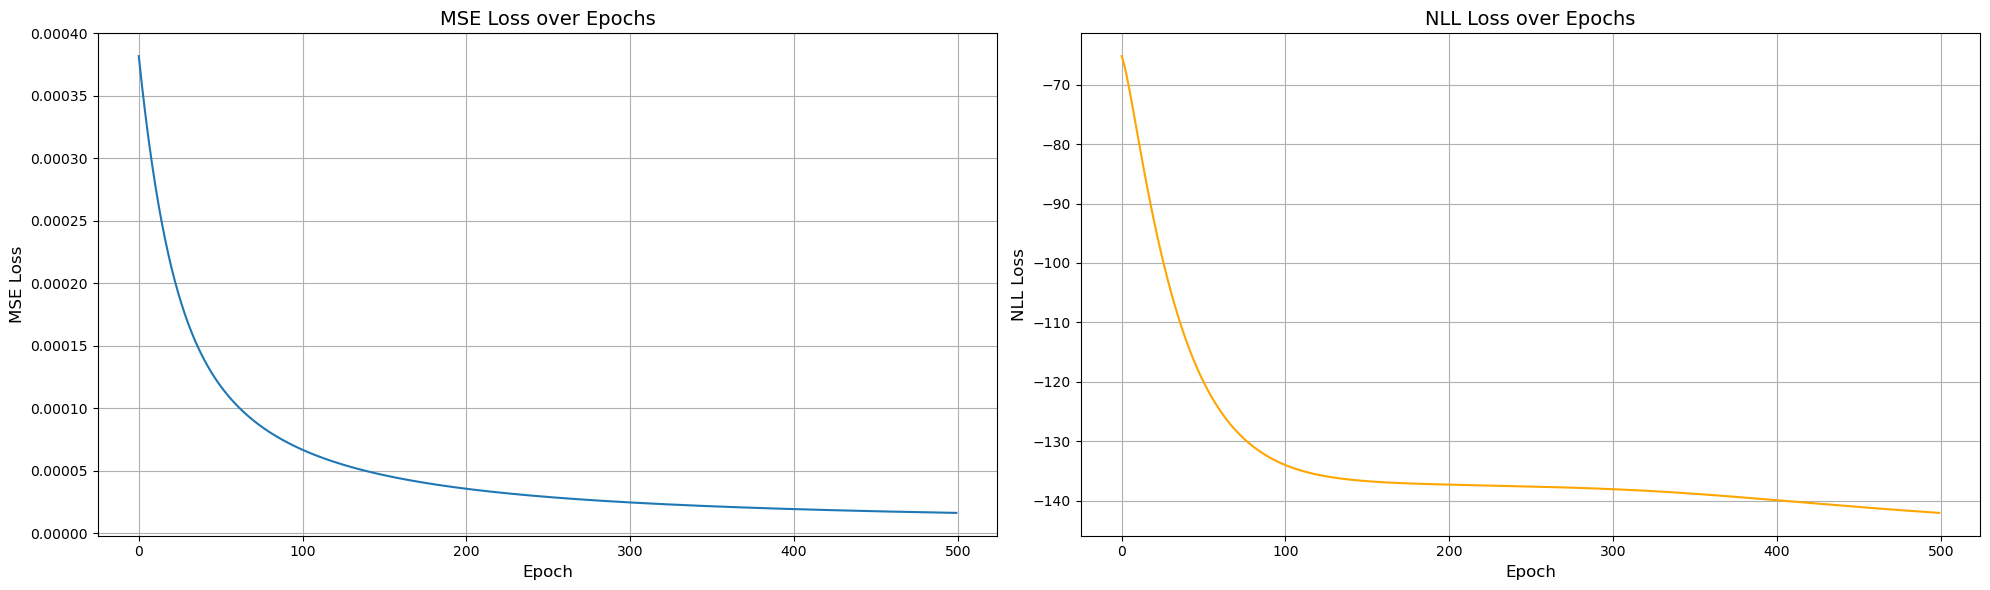

In [28]:
# Plot the training loss history for showing convergence

# Create 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# MSE loss convergence
axes[0].plot(mse_loss_history, label='MSE Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('MSE Loss over Epochs', fontsize=14)
axes[0].grid()

# NLL loss convergence
axes[1].plot(nll_loss_history, label='NLL Loss', color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('NLL Loss', fontsize=12)
axes[1].set_title('NLL Loss over Epochs', fontsize=14)
axes[1].grid()

plt.tight_layout()
plt.show()

## Forecast scheme

We would focus on the implementation of 1-step volatility forecast as our model is GNGARCH($1,1,[1],[1]$) - so just the previous 1-step return and volatility as the past information are taken into account. This is also mentioned in the previous loss functions: where we would use the previous 1-step data as the previous data for us to deduce the current variance and covariance via `compute_conditional`.

Hence our initialisation value of variance and covariance could be the variance/covariance of (last rolling window) of the training dataset, and we pick the last datapoint in the training dataset as the starting log-return. It would look like:

- The parameters are `params_mse` for MSE, and `params_nll` for NLL/QLIKE.

- The time interval for simulation `T` should be the length of `val_log_returns`.

- The initial state `X0` should be the final log-returns in the training set `log_returns`.

- The initial covariance `cov0` can be the covariance matrix of the training data `log_returns`, with the initial variance `var0` being as the diagonal entries.

In [29]:
params_mse = {
    'alpha0': 0.0232,
    'alpha1': 0.0702,
    'gamma1': 0.1693,
    'beta11': 0.0236,
    'delta11': 0.0432
}

params_nll = {
    'alpha0': 0.0005,
    'alpha1': 0.1648,
    'gamma1': 0.7072,
    'beta11': 0.0008,
    'delta11': 0.0039
}

params_mse_Zhou = {
    'alpha0':0.0219,
    'alpha1':0.0699,
    'gamma1':0.1499,
    'beta11':0.0225
}

params_nll_Zhou = {
    'alpha0':0.0004,
    'alpha1':0.4656,
    'gamma1':0.4035,
    'beta11':0.0043
}

In [30]:
def compute_B_t(X_t):
    """
    Given X_t of shape (1, d), compute and return the (d, d) matrix B_t.
    """
    B_t = np.outer(X_t, X_t)
    np.fill_diagonal(B_t, 0.0)  # minus the diagonal entries
    return B_t

def compute_D_t(cov_t):
    """
    Given the current covariance matrix Sigma_t, compute and return the (d, d) matrix D_t.
    """
    D_t = cov_t.copy()
    np.fill_diagonal(D_t, 0.0)
    return D_t

def ensure_posdef(cov_mat):
    """
    Ensure covariance matrix is positive definite and not ill-conditioned by adding jitter, 
    so we can use Cholesky decomposition.
    """
    
    d = cov_mat.shape[0]
    
    # Compute the eigenvalues and check if the matrix is positive definite
    min_eigval = min(np.linalg.eigvalsh(cov_mat))
    jitter = np.zeros_like(cov_mat)  # initialise jitter to zero
    # Set a threshold for jitter, ensuring PD and not ill-conditioned 
    # this value is normally 1e-3 or 1e-4, as even smaller thresholds may lead slow convergence (still ill-conditioned)
    # a big threshold may perturb the covariance matrix too much
    threshold = 1e-3
    # If the minimum eigenvalue is less than threshold, we need to add jitter to ensure PD
    if min_eigval < threshold:
        jitter = (-min_eigval + threshold) * np.eye(d, dtype=cov_mat.dtype)
            
        cov_mat += jitter
        return cov_mat

In [31]:
def compute_conditional(params, W_s, X_prev, var_prev, cov_prev):
    """Vectorised computation with proper exclusions"""
    # Unpack parameters from the dictionary
    alpha0  = params['alpha0']
    alpha1  = params['alpha1']
    gamma1  = params['gamma1']
    beta11  = params['beta11']
    delta11 = params['delta11']
        
    # Vectorised variance update
    clustering_term = beta11 * (W_s @ (X_prev ** 2))
    persistence_term = delta11 * (W_s @ var_prev)
    var_curr = alpha0 + alpha1 * (X_prev ** 2) + gamma1 * var_prev + clustering_term + persistence_term
        
    # Vectorised covariance update
    # Base GARCH component
    base_cov = alpha0 + alpha1 * np.outer(X_prev, X_prev) + gamma1 * cov_prev
        
    # Neighbouring clustering effect using vectorisation
    compute_B_prev = compute_B_t(X_prev)
    clustering_i_neighbour = W_s @ compute_B_prev
    clustering_j_neighbour = compute_B_prev @ W_s.T
    clustering_neighbour = 0.5 * beta11 * (clustering_i_neighbour + clustering_j_neighbour)
        
    # Neighbouring persistence effect using vectorisation
    compute_D_prev = compute_D_t(cov_prev)
    persistence_i_neighbour = W_s @ compute_D_prev
    persistence_j_neighbour = compute_D_prev @ W_s.T
    persistence_neighbour = 0.5 * delta11 * (persistence_i_neighbour + persistence_j_neighbour)
        
    # Combine components, both based part and neighbouring part
    cov_curr = base_cov + clustering_neighbour + persistence_neighbour
    cov_curr[range(d), range(d)] = var_curr  # Set diagonal
    cov_curr = ensure_posdef(cov_curr)  # Ensure positive definiteness
        
    return var_curr, cov_curr

In [ ]:
def network_GARCH_cond_var_forecast(W, S, params, train_data, val_data, window_size=60):
    """
    Compute the conditional variance forecast for a network GARCH (global GNGARCH(1,1,[1],[1])) over T time steps for a network with d nodes.

    Args:
        W (np.ndarray): node weight matrix of shape (d, d), where d is the number of nodes.
        S (np.ndarray): r-stage adjacency matrix of shape (d, d), where d is the number of nodes.
        params (dict): dictionary containing GNGARCH parameters:
            alpha0: positive float
            alpha1: non-negative float
            gamma1: non-negative float
            beta11: non-negative float
            delta11: non-negative float
        train_data (pd.DataFrame): log-return from training data.
        val_data (pd.DataFrame): log-return from validation data.
        window_size (int): the rolling window size, default 60.
    
    Returns:
        cond_var_forecast (np.ndarray): an array of shape (T, d) containing the conditional variance forecast for each node at each time step.
    """
    
    # Dimensionality check, based on the number of nodes
    T, d = val_data.shape
    d = W.shape[0]
    # Validate input shapes
    assert W.shape == (d, d), 'W must be an (d,d) matrix'
    assert var0.shape == (d,)
    assert cov0.shape == (d, d)
    
    # Initialise var_prev and cov_prev by using var0 and cov0 from the training data
    if val_data.equals(train_data):
        # If validation data is the same as training data (simply meaning we examine on the training data), 
        # we can use the first row of train_data as initialisation
        X_prev = train_data.iloc[0].values
        var_prev = train_data.iloc[:window_size].var().values
        cov_prev = train_data.iloc[:window_size].cov().values
    else:
        # If validation data is different from training data, we can use the last row of train_data as initialisation
        # and the rolling window of size window_size to compute the initial variance and covariance
        X_prev = train_data.iloc[-1].values
        var_prev = train_data.iloc[-window_size-1:-1].var().values
        cov_prev = train_data.iloc[-window_size-1:-1].cov().values
    
    # Initialise the array storing conditional variance forecasts
    cond_var_forecast = np.zeros((T, d))

    # Precompute 1-stage neighbour lists
    # This can be done by using the Hadamard product of W and S, denoted as W_s
    W_s = W * S
    
    # Iteration over time steps for simulation from t=1 to T-1
    for t in range(1, T+1):
        # Compute the 1-step forward conditional variance and covariance
        var_curr, cov_curr = compute_conditional(params, W_s, X_prev, var_prev, cov_prev)
        # Update and store the conditional variance forecast for each node
        cond_var_forecast[t-1] = var_curr
        
        # Update state
        var_prev = var_curr
        cov_prev = cov_curr
        X_prev = val_data.iloc[t-1].values
        
    return cond_var_forecast

In [33]:
# A conditional variance forecast on the training data
cond_var_forecast_mse = network_GARCH_cond_var_forecast(W_total, A, params_mse, log_returns, log_returns, window_size=60)
cond_var_forecast_nll = network_GARCH_cond_var_forecast(W_total, A, params_nll, log_returns, log_returns, window_size=60)

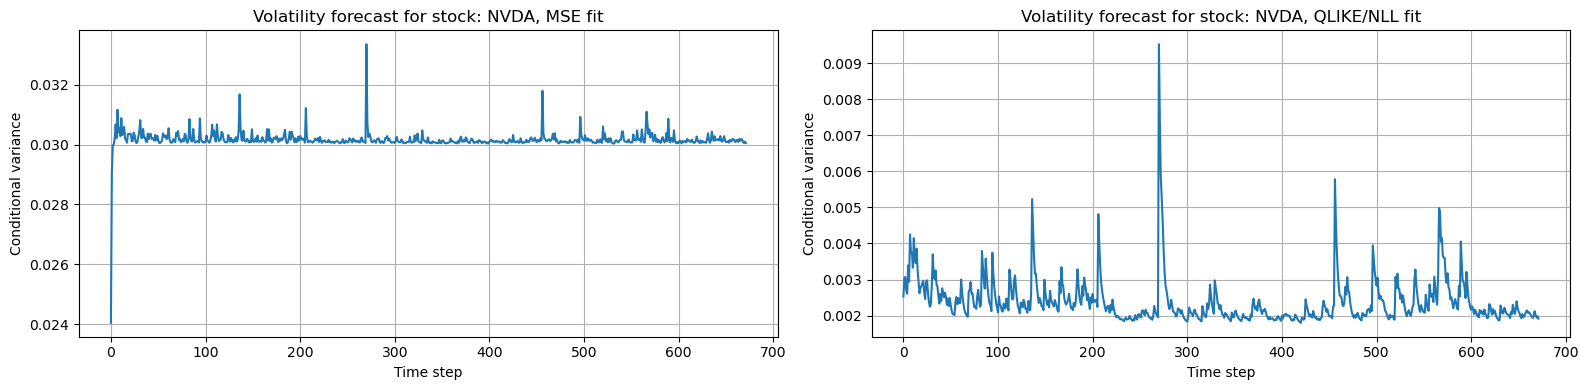

In [34]:
# Create a 3×2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axes[0].plot(cond_var_forecast_mse[:, 0])
axes[0].set_title(f'Volatility forecast for stock: NVDA, MSE fit')
axes[0].set_xlabel('Time step')
axes[0].set_ylabel(f'Conditional variance')
axes[0].grid()

axes[1].plot(cond_var_forecast_nll[:, 0])
axes[1].set_title(f'Volatility forecast for stock: NVDA, QLIKE/NLL fit')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel(f'Conditional variance')
axes[1].grid()

fig.tight_layout()
plt.show()

Also write functions for forecasting scheme of Zhou's network GARCH model.

In [35]:
def compute_conditional_Zhou(params, W_s, X_prev, var_prev, cov_prev):
    """Vectorised computation with proper exclusions"""
    # Unpack parameters from the dictionary
    alpha0  = params['alpha0']
    alpha1  = params['alpha1']
    gamma1  = params['gamma1']
    beta11  = params['beta11']
        
    # Vectorised variance update
    clustering_term = beta11 * (W_s @ (X_prev ** 2))
    var_curr = alpha0 + alpha1 * (X_prev ** 2) + gamma1 * var_prev + clustering_term
        
    # Vectorised covariance update (setting diagonal only)
    cov_curr = np.zeros_like(cov_prev)  # initialisation
    cov_curr[range(d), range(d)] = var_curr  # Set diagonal
        
    return var_curr, cov_curr

In [ ]:
def network_GARCH_Zhou_cond_var_forecast(W, S, params, train_data, val_data, window_size=60):
    """
    Compute the conditional variance forecast for a network GARCH (global GNGARCH(1,1,[1],[1])) over T time steps for a network with d nodes.

    Args:
        W (np.ndarray): node weight matrix of shape (d, d), where d is the number of nodes.
        S (np.ndarray): r-stage adjacency matrix of shape (d, d), where d is the number of nodes.
        params (dict): dictionary containing GNGARCH parameters:
            alpha0: positive float
            alpha1: non-negative float
            gamma1: non-negative float
            beta11: non-negative float
        train_data (pd.DataFrame): log-return from training data.
        val_data (pd.DataFrame): log-return from validation data.
        window_size (int): the rolling window size, default 60.
    
    Returns:
        cond_var_forecast (np.ndarray): an array of shape (T, d) containing the conditional variance forecast for each node at each time step.
    """
    
    # Dimensionality check, based on the number of nodes
    T, d = val_data.shape
    d = W.shape[0]
    # Validate input shapes
    assert W.shape == (d, d), 'W must be an (d,d) matrix'
    assert var0.shape == (d,)
    assert cov0.shape == (d, d)
    
    # Initialise var_prev and cov_prev by using var0 and cov0 from the training data
    if val_data.equals(train_data):
        # If validation data is the same as training data (simply meaning we examine on the training data), 
        # we can use the first row of train_data as initialisation
        X_prev = train_data.iloc[0].values
        var_prev = train_data.iloc[:window_size].var().values
        cov_prev = train_data.iloc[:window_size].cov().values
    else:
        # If validation data is different from training data, we can use the last row of train_data as initialisation
        # and the rolling window of size window_size to compute the initial variance and covariance
        X_prev = train_data.iloc[-1].values
        var_prev = train_data.iloc[-window_size-1:-1].var().values
        cov_prev = train_data.iloc[-window_size-1:-1].cov().values
    
    # Initialise the array storing conditional variance forecasts
    cond_var_forecast = np.zeros((T, d))

    # Precompute 1-stage neighbour lists
    # This can be done by using the Hadamard product of W and S, denoted as W_s
    W_s = W * S
    
    # Iteration over time steps for simulation from t=1 to T-1
    for t in range(1, T+1):
        # Compute the 1-step forward conditional variance and covariance
        var_curr, cov_curr = compute_conditional_Zhou(params, W_s, X_prev, var_prev, cov_prev)
        # Update and store the conditional variance forecast for each node
        cond_var_forecast[t-1] = var_curr
        
        # Update state
        var_prev = var_curr
        cov_prev = cov_curr
        X_prev = val_data.iloc[t-1].values
        
    return cond_var_forecast

In [37]:
# A conditional variance forecast on the training data
cond_var_forecast_mse_Zhou = network_GARCH_Zhou_cond_var_forecast(W_total, A, params_mse, log_returns, log_returns, window_size=60)
cond_var_forecast_nll_Zhou = network_GARCH_Zhou_cond_var_forecast(W_total, A, params_nll, log_returns, log_returns, window_size=60)

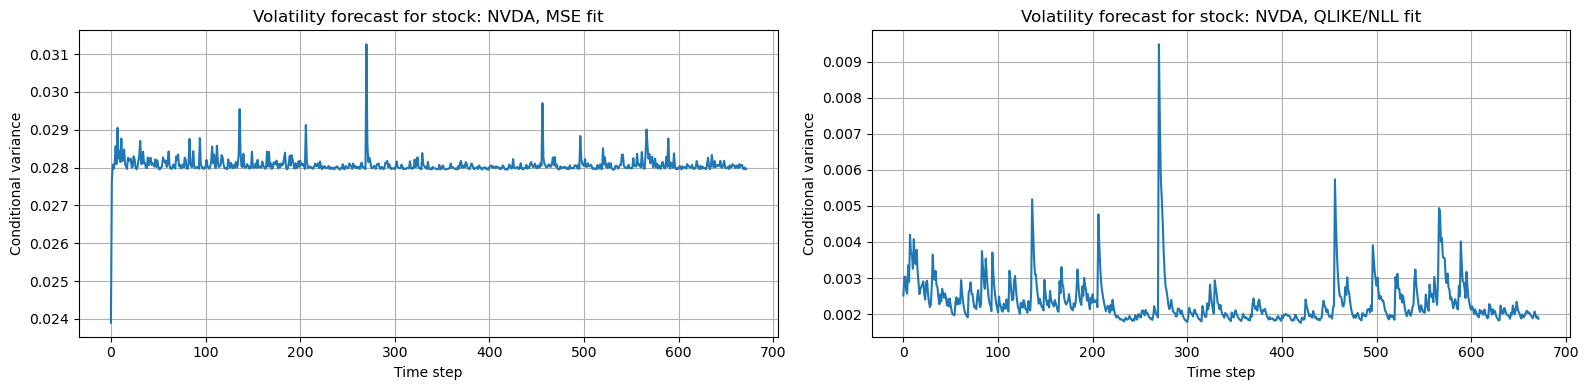

In [38]:
# Create a 3×2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axes[0].plot(cond_var_forecast_mse_Zhou[:, 0])
axes[0].set_title(f'Volatility forecast for stock: NVDA, MSE fit')
axes[0].set_xlabel('Time step')
axes[0].set_ylabel(f'Conditional variance')
axes[0].grid()

axes[1].plot(cond_var_forecast_nll_Zhou[:, 0])
axes[1].set_title(f'Volatility forecast for stock: NVDA, QLIKE/NLL fit')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel(f'Conditional variance')
axes[1].grid()

fig.tight_layout()
plt.show()

---

We first introduce the <code>dynamic_rescale</code> function as introduced in the thesis.

In [39]:
def dynamic_rescale(cond_var, squared_return, rescale_window=252):
    """
    Dynamically rescales conditional variance forecasts to match realized variance levels
    while preserving relative dynamics.
    
    Args:
        cond_var (pd.Series): Conditional variance forecasts
        squared_return (pd.Series): Squared (log-)returns
        rescale_window (int): Window for dynamic scaling (default 252 trading days)
    
    Returns:
        scaled_cond_var (pd.Series): Rescaled conditional variance
    """
    # Calculate rolling realized variance
    rolling_realised_var = squared_return.rolling(window=rescale_window).mean()
    
    # Calculate rolling forecast variance (realised measure)
    rolling_forecast_var = cond_var.rolling(window=rescale_window).mean()
    
    # Compute dynamic scaling factor
    ratio = rolling_realised_var / rolling_forecast_var
    ratio = ratio.replace([np.inf, -np.inf], np.nan).bfill()
    
    # Apply scaling while preserving original mean
    scaled_cond_var = cond_var * ratio
    return scaled_cond_var

The following code shows the conditional variance comparison on the training set, with a selected stock (in thesis we choose NVDA).

In [ ]:
def cond_var_comparison_inst(df, stock_name, 
                             cond_var_forecast_mse, cond_var_forecast_nll, 
                             cond_var_forecast_mse_Zhou, cond_var_forecast_nll_Zhou,
                             lam=0.94, params_garch=None, rescale_window=252):
    """Generate a graph comparing the conditional variance on a log-return dataset instantaneously, 
    between the squared log-return values (which can be viewed as a proxy of instantaneous conditional variance)
    and the introduced network GARCH model, both MSE and NLL.

    Args:
        df (pd.DataFrame): the dataset of log-return series.
        stock_name (string): name of the stock, must be a string.
        cond_var_forecast_mse (np.ndarray): the forecast node conditional variance from the model fitted by MSE.
        cond_var_forecast_nll (np.ndarray): the forecast node conditional variance from the model fitted by QLIKE/NLL.
        cond_var_forecast_mse_Zhou (np.ndarray): the forecast node conditional variance from the Zhou's model fitted by MSE.
        cond_var_forecast_nll_Zhou (np.ndarray): the forecast node conditional variance from the Zhou's model fitted by QLIKE/NLL.
        lam (float): the value of parameter lambda in RiskMetrics, default 0.94.
        params_garch (pd.Series): the parameters of fitted univariate GARCH(1,1) model on the single stock, default None.
        rescale_window (int): the window size for dynamic rescaling, default 252 (trading days).
    """

    if not isinstance(stock_name, str):
        raise ValueError('The stock name must be a string, please include quotation mark if needed.')
    
    
    stock_idx = df.columns.get_loc(stock_name)  # extract the corresponding index for the stock
    
    squared_return = df[stock_name]**2
    dates = df.index
    
    cond_var_mse = pd.Series(cond_var_forecast_mse[:, stock_idx], index=df.index)
    cond_var_nll = pd.Series(cond_var_forecast_nll[:, stock_idx], index=df.index)
    cond_var_mse_Zhou = pd.Series(cond_var_forecast_mse_Zhou[:, stock_idx], index=df.index)
    cond_var_nll_Zhou = pd.Series(cond_var_forecast_nll_Zhou[:, stock_idx], index=df.index)
    
    # Univariate GARCH(1,1) model
    if params_garch is None:
        # Fit the univariate GARCH(1,1) on the df
        am = arch_model(df[stock_name].values, vol='Garch', p=1, q=1, rescale=False, dist='normal')
        res = am.fit(disp='off', show_warning=False)  # do not show the fit process and any warnings
        params_garch = res.params  # best-fit GARCH model on df
    else:
        # Use fitted GARCH parameters
        am = arch_model(df[stock_name].values, vol='GARCH', p=1, q=1, rescale=False, dist='normal')
        res = am.fit(update_freq=0, disp='off', starting_values=params_garch, show_warning=False)
    garch_vol = res.conditional_volatility  # univariate GARCH instant volatility
    cond_var_garch = pd.Series(garch_vol**2, index=df.index)
    
    # RiskMetrics (rm) conditional variance forecast, with initialisation as a pd.Series
    cond_var_rm = pd.Series(index=dates, dtype=float)
    cond_var_rm.iloc[0] = squared_return.iloc[0]
    for t in range(1, len(cond_var_rm)):
        # Update via trading days
        cond_var_rm.iloc[t] = lam * cond_var_rm.iloc[t-1] + (1 - lam) * squared_return.iloc[t-1] 
    
    # Apply the rescaling
    cond_var_garch = dynamic_rescale(cond_var_garch, squared_return, rescale_window=rescale_window)
    cond_var_rm = dynamic_rescale(cond_var_rm, squared_return, rescale_window=rescale_window)
    cond_var_mse = dynamic_rescale(cond_var_mse, squared_return, rescale_window=rescale_window)
    cond_var_nll = dynamic_rescale(cond_var_nll, squared_return, rescale_window=rescale_window)
    cond_var_mse_Zhou = dynamic_rescale(cond_var_mse_Zhou, squared_return, rescale_window=rescale_window)
    cond_var_nll_Zhou = dynamic_rescale(cond_var_nll_Zhou, squared_return, rescale_window=rescale_window)
    
    # Plot the squared returns
    plt.figure(figsize=(10, 3))
    plt.plot(dates, squared_return, label='Squared log-return', linewidth=2, alpha=0.7)
    plt.title(f'Squared log-return {stock_name}', fontsize=20)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Squared log-return', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(fontsize=16)
    plt.grid(alpha=0.3)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    axes[0].plot(dates, cond_var_mse, label='cond. var. GNGARCH', color='r', linewidth=2, alpha=0.7)
    axes[0].set_title(f'Conditional variance via MSE parameters for {stock_name}', fontsize=20)
    axes[0].set_xlabel('Date', fontsize=16)
    axes[0].set_ylabel('Conditional Variance', fontsize=16)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].legend(fontsize=16)
    axes[0].grid(alpha=0.3)

    axes[1].plot(dates, cond_var_nll, label='cond. var. GNGARCH', color='r', linewidth=2, alpha=0.7)
    axes[1].set_title(f'Conditional variance via QMLE parameters for {stock_name}', fontsize=20)
    axes[1].set_xlabel('Date', fontsize=16)
    axes[1].set_ylabel('Conditional Variance', fontsize=16)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].legend(fontsize=16)
    axes[1].grid(alpha=0.3)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    axes[0].plot(dates, cond_var_garch, label='cond. var. GARCH', color='g', linewidth=2, alpha=0.7)
    axes[0].plot(dates, cond_var_rm, label='cond. var. RiskMetrics', color='purple', linewidth=2, alpha=0.7)
    axes[0].plot(dates, cond_var_nll, label='cond. var. GNGARCH', color='r', linewidth=3, alpha=0.7)
    axes[0].set_title(f'Conditional variance via QMLE parameters for {stock_name}', fontsize=20)
    axes[0].set_xlabel('Date', fontsize=16)
    axes[0].set_ylabel('Conditional Variance', fontsize=16)
    axes[0].tick_params(axis='both', which='major', labelsize=15)
    axes[0].legend(fontsize=16)
    axes[0].grid(alpha=0.3)

    axes[1].plot(dates, cond_var_nll_Zhou, label='cond. var. Zhou', color='k', linewidth=2, alpha=0.7)
    axes[1].plot(dates, cond_var_nll, label='cond. var. GNGARCH', color='r', linewidth=3, alpha=0.7)
    axes[1].set_title(f'Conditional variance via QMLE parameters for {stock_name}', fontsize=20)
    axes[1].set_xlabel('Date', fontsize=16)
    axes[1].set_ylabel('Conditional Variance', fontsize=16)
    axes[1].tick_params(axis='both', which='major', labelsize=15)
    axes[1].legend(fontsize=16)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return params_garch

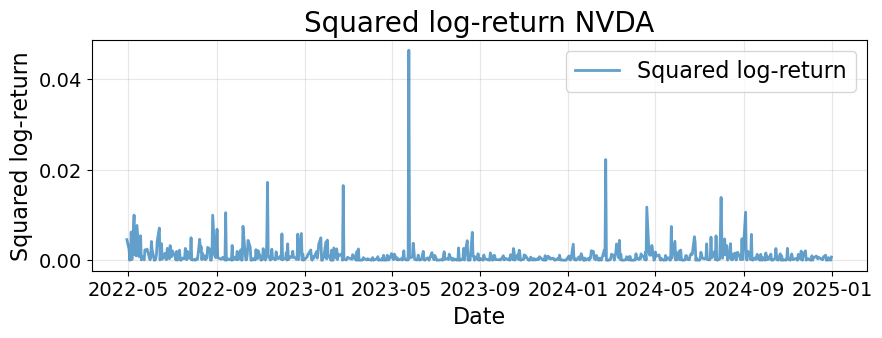

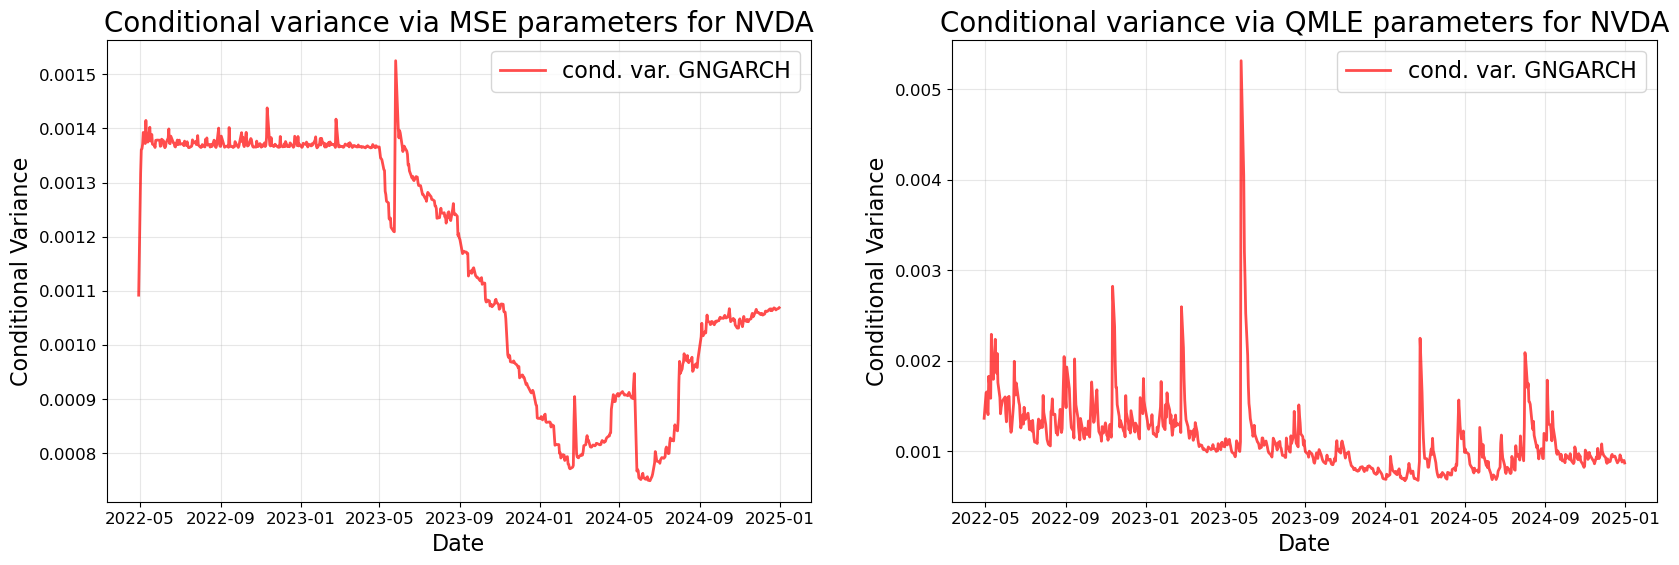

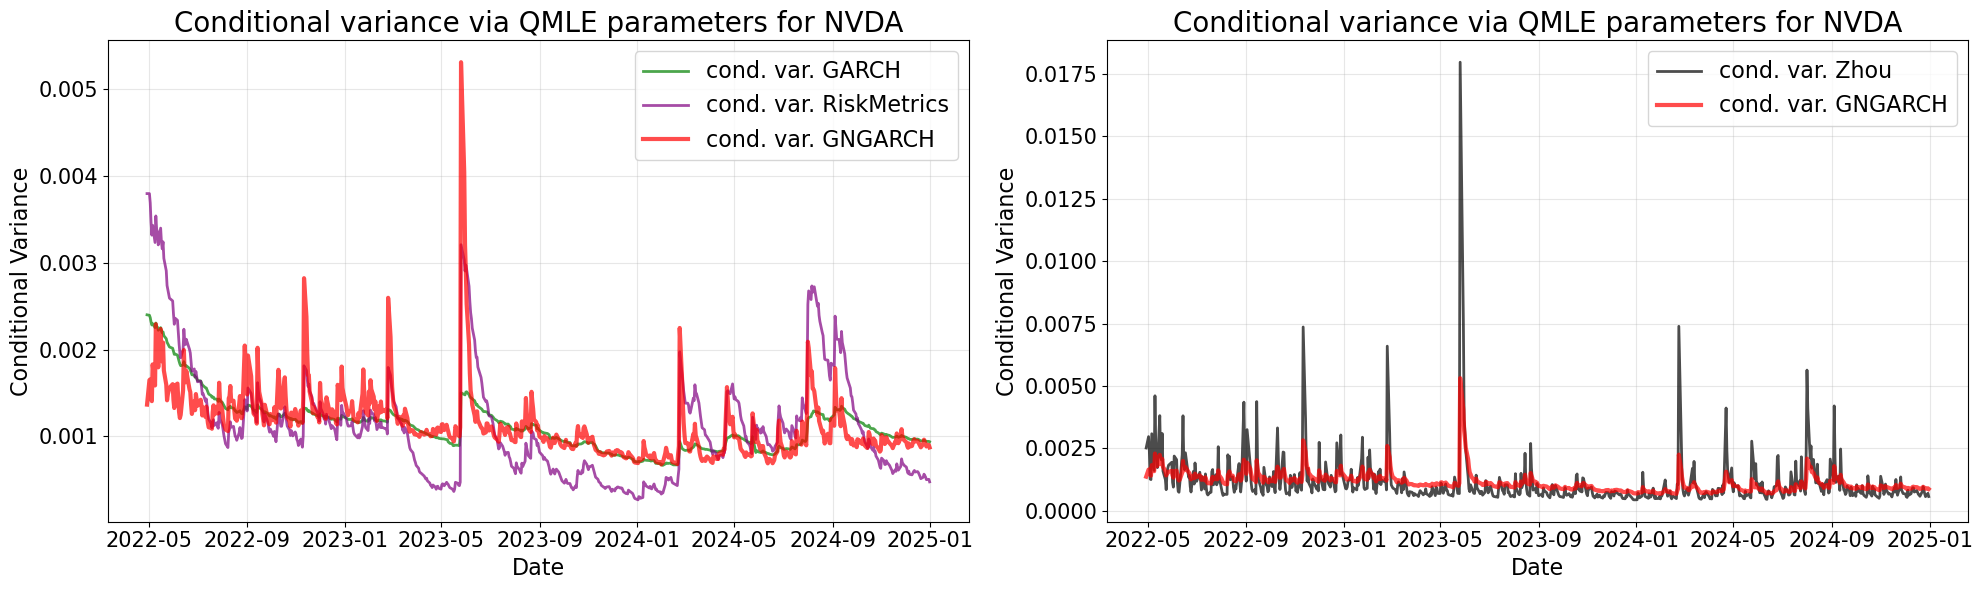

In [134]:
cond_var_forecast_mse = network_GARCH_cond_var_forecast(W_total, A, params_mse, log_returns, log_returns, window_size=60)
cond_var_forecast_nll = network_GARCH_cond_var_forecast(W_total, A, params_nll, log_returns, log_returns, window_size=60)
cond_var_forecast_mse_Zhou = network_GARCH_Zhou_cond_var_forecast(W_total, A, params_mse_Zhou, log_returns, log_returns, window_size=60)
cond_var_forecast_nll_Zhou = network_GARCH_Zhou_cond_var_forecast(W_total, A, params_nll_Zhou, log_returns, log_returns, window_size=60)

params_garch = cond_var_comparison_inst(log_returns, 'NVDA', 
                                        cond_var_forecast_mse, cond_var_forecast_nll,
                                        cond_var_forecast_mse_Zhou, cond_var_forecast_nll_Zhou)

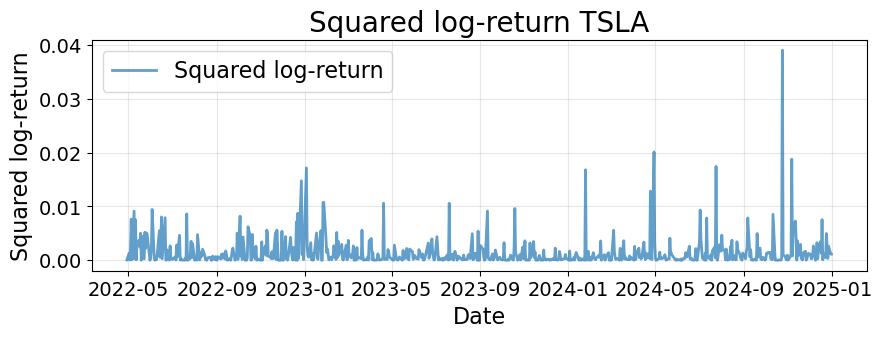

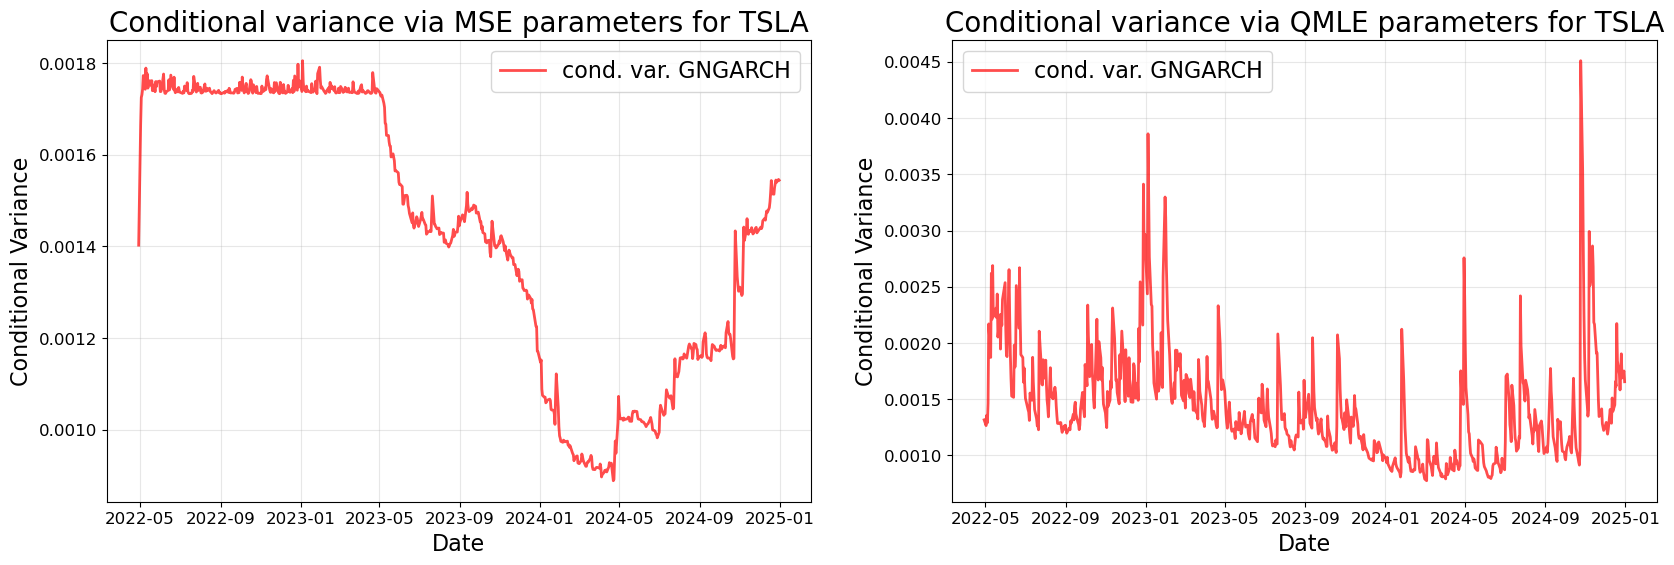

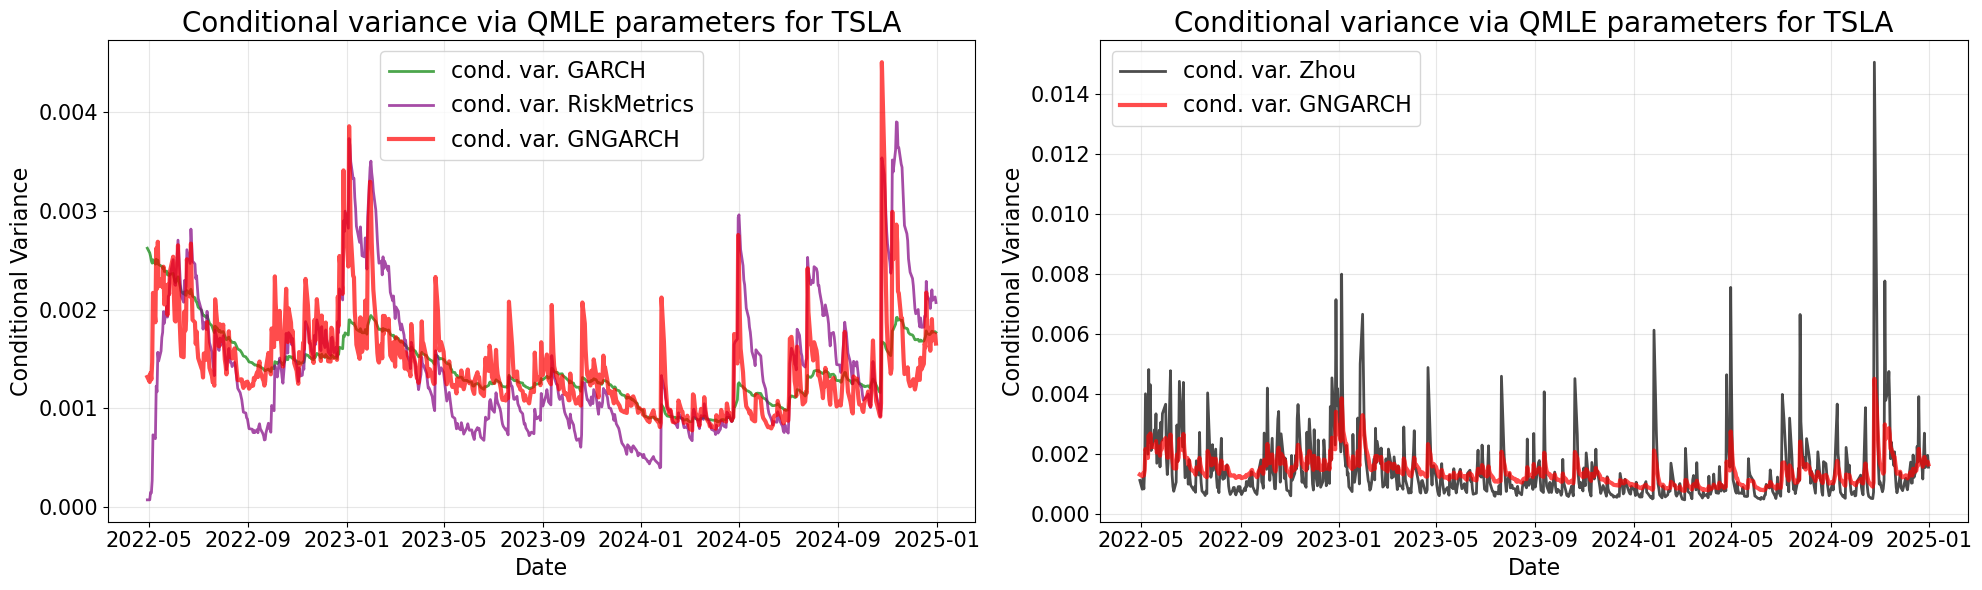

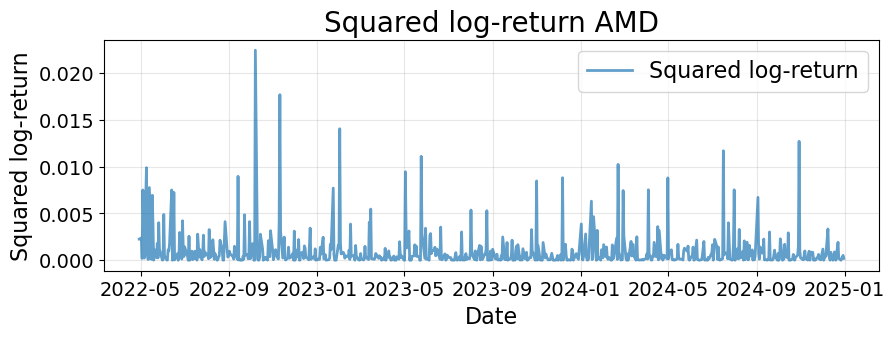

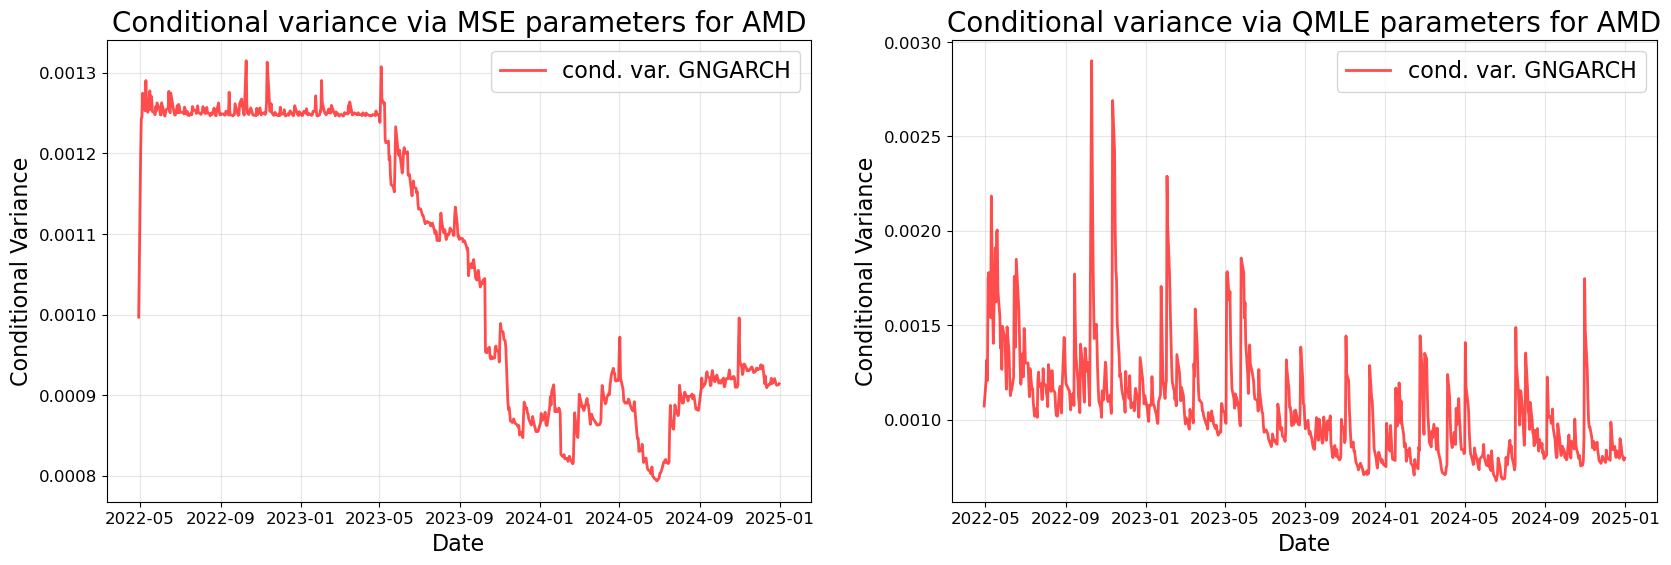

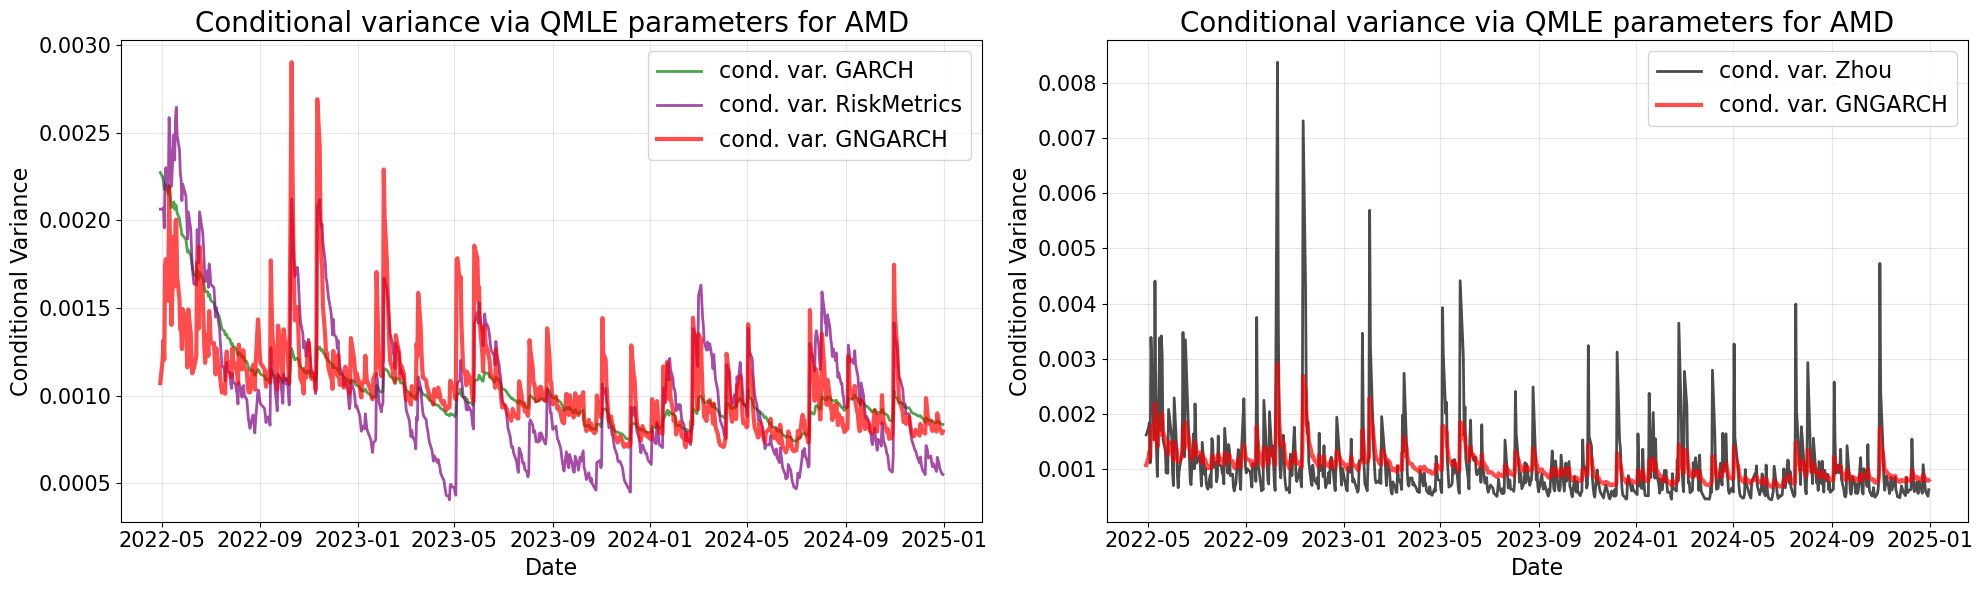

In [136]:
# Try some other stocks other than NVDA
params_garch2 = cond_var_comparison_inst(log_returns, 'TSLA', 
                                        cond_var_forecast_mse, cond_var_forecast_nll,
                                        cond_var_forecast_mse_Zhou, cond_var_forecast_nll_Zhou)

params_garch3 = cond_var_comparison_inst(log_returns, 'AMD', 
                                        cond_var_forecast_mse, cond_var_forecast_nll,
                                        cond_var_forecast_mse_Zhou, cond_var_forecast_nll_Zhou)

Next we augment the conditional covariance together. The following function contains both conditional variance and the conditional covariance forecast.

In [ ]:
def network_GARCH_cond_forecast(W, S, params, train_data, val_data, window_size=60):
    """
    Compute the conditional variance and covariance forecast for a network GARCH (global GNGARCH(1,1,[1],[1])) over T time steps for a network with d nodes.

    Args:
        W (np.ndarray): node weight matrix of shape (d, d), where d is the number of nodes.
        S (np.ndarray): r-stage adjacency matrix of shape (d, d), where d is the number of nodes.
        params (dict): dictionary containing GNGARCH parameters:
            alpha0: positive float
            alpha1: non-negative float
            gamma1: non-negative float
            beta11: non-negative float
            delta11: non-negative float
        train_data (pd.DataFrame): log-return from training data.
        val_data (pd.DataFrame): log-return from validation data.
        window_size (int): the rolling window size, default 60.
    
    Returns:
        cond_var_forecast (np.ndarray): an array of shape (T, d) containing the conditional variance forecast for each node at each time step.
        cond_cov_forecast (np.ndarray): an array of shape (T, d, d) containing the conditional covariance forecast for all nodes at each time step.
    """
    
    # Dimensionality check, based on the number of nodes
    T, d = val_data.shape
    d = W.shape[0]
    # Validate input shapes
    assert W.shape == (d, d), 'W must be an (d,d) matrix'
    assert var0.shape == (d,)
    assert cov0.shape == (d, d)
    
    # Initialise var_prev and cov_prev by using var0 and cov0 from the training data
    if val_data.equals(train_data):
        # If validation data is the same as training data (simply meaning we examine on the training data), 
        # we can use the first row of train_data as initialisation
        X_prev = train_data.iloc[0].values
        var_prev = train_data.iloc[:window_size].var().values
        cov_prev = train_data.iloc[:window_size].cov().values
    else:
        # If validation data is different from training data, we can use the last row of train_data as initialisation
        # and the rolling window of size window_size to compute the initial variance and covariance
        X_prev = train_data.iloc[-1].values
        var_prev = train_data.iloc[-window_size-1:-1].var().values
        cov_prev = train_data.iloc[-window_size-1:-1].cov().values
    
    # Initialise the array storing conditional variance and covariance forecasts
    cond_var_forecast = np.zeros((T, d))
    cond_cov_forecast = np.zeros((T, d, d))

    # Precompute 1-stage neighbour lists
    # This can be done by using the Hadamard product of W and S, denoted as W_s
    W_s = W * S
    
    # Iteration over time steps for simulation from t=1 to T-1
    for t in range(1, T+1):
        # Compute the 1-step forward conditional variance and covariance
        var_curr, cov_curr = compute_conditional(params, W_s, X_prev, var_prev, cov_prev)
        # Update and store the conditional variance/covariance forecast
        cond_var_forecast[t-1] = var_curr
        cond_cov_forecast[t-1] = cov_curr
        
        # Update state
        var_prev = var_curr
        cov_prev = cov_curr
        X_prev = val_data.iloc[t-1].values
        
    return cond_var_forecast, cond_cov_forecast

In [117]:
def cond_cov_inst(df, stock_name1, stock_name2, 
                  cond_cov_forecast_mse, cond_cov_forecast_nll, rescale_window=252):
    """
    Compare model conditional covariance (co-volatility) forecasts with the empirical cross-product of two stocks as proxy.

    Args:
        df (pd.DataFrame): daily log-return series, index = dates, columns = stock names.
        stock_name1 (str): name of the first stock (column in df).
        stock_name2 (str): name of the second stock (column in df).
        cond_cov_forecast_mse (np.ndarray): model forecasts from MSE fit, shape (T, d, d).
        cond_cov_forecast_nll (np.ndarray): model forecasts from QMLE/NLL fit, shape (T, d, d).
        rescale_window (int): window for dynamic rescaling, default 252.
    """

    if not isinstance(stock_name1, str) or not isinstance(stock_name2, str):
        raise ValueError("Stock names must be strings.")
    if stock_name1 not in df.columns or stock_name2 not in df.columns:
        raise KeyError("One or both stock names are not columns of `df`.")

    # Extract indices for stocks
    stock_idx1 = df.columns.get_loc(stock_name1)
    stock_idx2 = df.columns.get_loc(stock_name2)

    # Define dates and total T
    dates = df.index
    T = len(dates)

    # Extract the (i,j) co-volatility series over time
    cond_cov_mse = pd.Series(cond_cov_forecast_mse[:, stock_idx1, stock_idx2], index=dates)
    cond_cov_nll = pd.Series(cond_cov_forecast_nll[:, stock_idx1, stock_idx2], index=dates)

    # Empirical co-volatility proxy: cross-product of returns r_i * r_j (instantaneous)
    cross_prod = df[stock_name1] * df[stock_name2]

    # Dynamic rescale the model forecasts to align level with observed proxy (preserves dynamics)
    cond_cov_mse = dynamic_rescale(cond_cov_mse, cross_prod, rescale_window=rescale_window)
    cond_cov_nll = dynamic_rescale(cond_cov_nll, cross_prod, rescale_window=rescale_window)

    s = pd.Series(cond_cov_nll, index=dates)  # convert back to a pd.Series, easy for taking the median and rolling median
    rolling_median = s.rolling(window=rescale_window).median()
    rolling_median = rolling_median.replace([np.inf, -np.inf], np.nan).bfill()  # replace nan with the first valid median

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    axes[0].plot(dates, cross_prod, label=f'Cross product', alpha=0.7)
    axes[0].axhline(0, color='k', linewidth=1.5, label='zero baseline')
    axes[0].set_title(f'Cross log-return product between {stock_name1} and {stock_name2}', fontsize=20)
    axes[0].set_xlabel('Date', fontsize=16)
    axes[0].set_ylabel('Cross log-return product', fontsize=16)
    axes[0].tick_params(axis='both', which='major', labelsize=15)
    axes[0].legend(fontsize=16)
    axes[0].grid(alpha=0.3)

    axes[1].plot(dates, cond_cov_nll, label='cond. cov. GNGARCH', color='r', alpha=0.7)
    axes[1].plot(rolling_median.index, rolling_median, color='k', linewidth=1.5, label=f'{rescale_window}-day rolling median')
    axes[1].set_title(f'Conditional covariance via QMLE parameters between {stock_name1} and {stock_name2}', fontsize=20)
    axes[1].set_xlabel('Date', fontsize=16)
    axes[1].set_ylabel('Conditional covariance', fontsize=16)
    axes[1].tick_params(axis='both', which='major', labelsize=15)
    axes[1].legend(fontsize=16)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return cond_cov_mse, cond_cov_nll, rolling_median

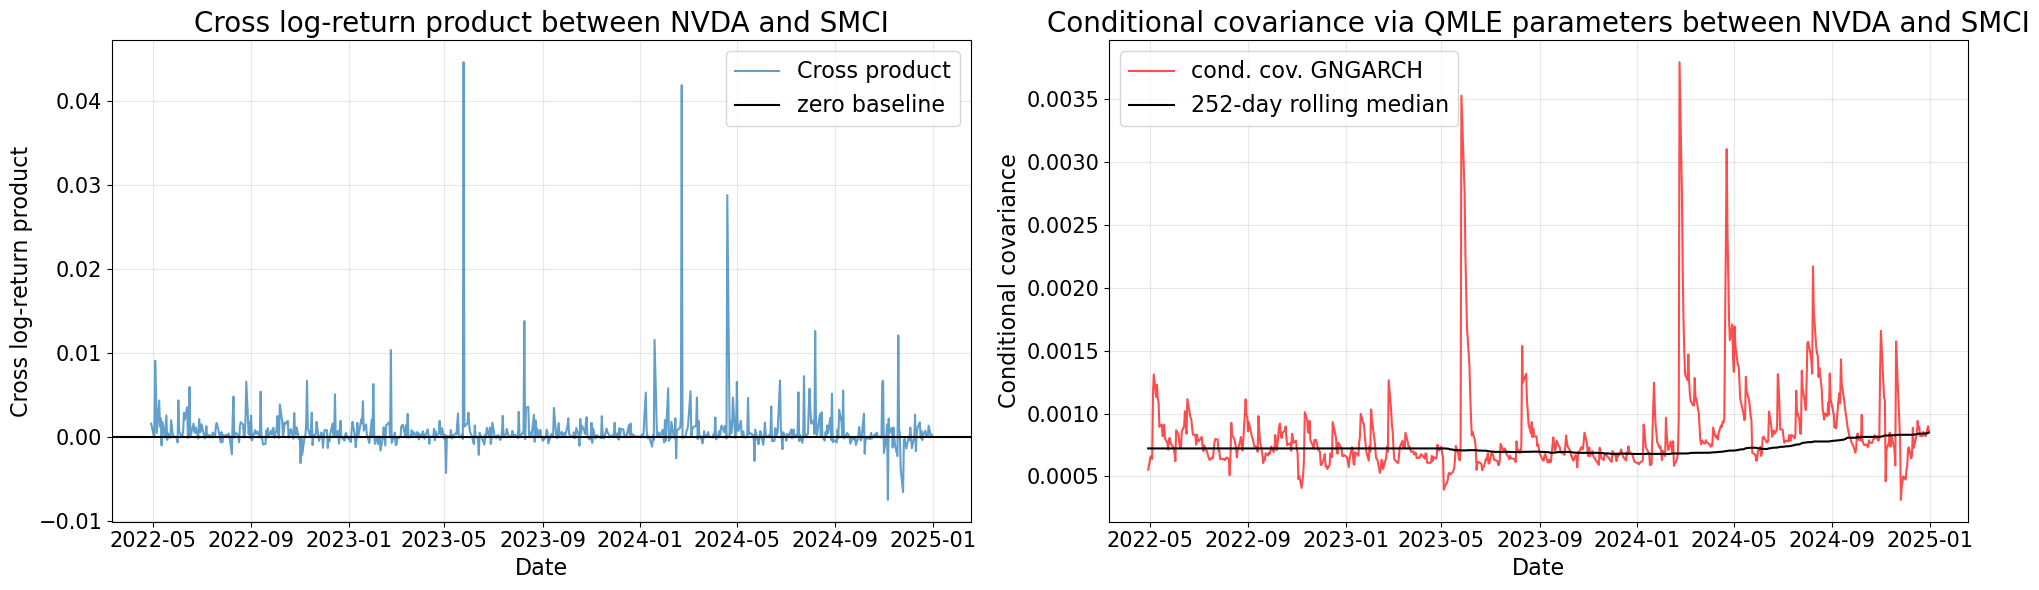

In [118]:
# A conditional variance and covariance forecast on the training data
cond_var_forecast_mse, cond_cov_forecast_mse = network_GARCH_cond_forecast(W_total, A, params_mse, log_returns, log_returns, window_size=60)
cond_var_forecast_nll, cond_cov_forecast_nll = network_GARCH_cond_forecast(W_total, A, params_nll, log_returns, log_returns, window_size=60)

cond_cov_mse, cond_cov_nll, rolling_median = cond_cov_inst(log_returns, 'NVDA', 'SMCI', cond_cov_forecast_mse, cond_cov_forecast_nll)

---

#### Prediction (using validation set)

We do 1-step forward forecasting scheme.

In [46]:
# Fetch high-frequency (minute-ly) closing prices
val_data = yf.download(
    tickers=tickers,
    start='2025-01-02',
    end='2025-06-30',
    interval='1d',
    group_by='ticker'
)

# Create clean DataFrame
val_closing_prices = pd.DataFrame({
    t: val_data[t]['Close'] for t in tickers
}).dropna()

# Calculate the daily log returns (trade working days)
val_log_returns = np.log(val_closing_prices).diff().dropna()
val_log_returns -= val_log_returns.mean()  # centering
val_log_returns

C:\Users\Brian\AppData\Local\Temp\ipykernel_3360\1699261782.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  val_data = yf.download(
[*********************100%***********************]  75 of 75 completed


,NVDA,TSLA,INTC,LCID,SOFI,F,PLTR,AAL,MRVL,QBTS,...,BMY,PTEN,OXY,PTON,ORCL,V,OKLO,C,ENPH,NKE
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-03,0.042477,0.080277,0.015715,0.085301,0.047397,0.022228,0.056022,0.001652,0.043084,-0.053291,...,0.008607,0.007534,0.015170,0.028994,-0.000273,0.000732,0.213121,0.013354,0.015652,-0.004809
2025-01-06,0.032659,0.002807,-0.035097,0.015061,0.028244,0.002713,-0.055580,0.035314,0.010205,0.107560,...,0.003454,0.008673,0.006348,-0.015621,-0.005813,-0.006844,0.088412,0.022523,-0.006087,-0.017942
2025-01-07,-0.065283,-0.040128,0.006061,-0.043115,-0.026796,-0.017587,-0.085938,0.013075,-0.020430,-0.069974,...,0.009595,0.002856,0.016461,-0.017087,-0.024355,-0.005275,-0.024539,0.011152,0.034046,0.001338
2025-01-08,-0.001311,0.002792,-0.007478,-0.061982,-0.026070,-0.003378,-0.030078,-0.001682,0.020268,-0.451400,...,-0.004281,-0.020620,-0.005794,-0.010489,0.004809,0.002091,-0.129421,-0.007405,-0.049153,-0.011070
2025-01-10,-0.031532,0.000816,-0.038372,0.016310,-0.029505,-0.010610,-0.018929,0.046782,-0.029916,-0.058764,...,-0.015889,0.012312,0.003361,0.028479,-0.053977,-0.016655,-0.042003,-0.027405,-0.038179,-0.001174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-23,0.001125,0.080429,0.004244,-0.010817,0.008843,0.013669,0.014293,0.029442,-0.034638,-0.049576,...,0.002791,-0.047195,-0.036299,0.032458,0.007055,0.014295,-0.057981,0.009845,-0.032004,0.016512
2025-06-24,0.024446,-0.022505,0.061245,0.007595,0.029774,-0.003189,0.018771,0.045634,0.063914,-0.001141,...,0.003853,-0.007128,-0.032805,0.036131,0.036963,0.021776,0.089045,0.020494,0.109482,0.010564
2025-06-25,0.041330,-0.037364,-0.016603,-0.010945,0.012778,-0.024902,-0.006917,-0.024225,0.012734,-0.057363,...,-0.005958,-0.036365,-0.000199,-0.002386,-0.023381,-0.019170,-0.096197,0.016509,-0.002417,-0.009563


In [47]:
def one_step_forecast(train_data, val_data, params, window_size=60):
    T_val, d = val_data.shape
    cond_var_forecast_arr = np.zeros((T_val, d))
    cond_cov_forecast_arr = np.zeros((T_val, d, d))
    
    # Initialise with training data
    current_data = train_data.copy()
    
    for i in range(T_val):
        # Get next validation observation
        next_obs = val_data.iloc[[i]]  # keep as DataFrame
        
        # Make 1-step forecast using current data
        cond_var_forecast, cond_cov_forecast = network_GARCH_cond_forecast(
            W_total, A, params, current_data, next_obs, window_size
        )
        
        # Store forecasts
        cond_var_forecast_arr[i] = cond_var_forecast
        cond_cov_forecast_arr[i] = cond_cov_forecast
        
        # Update data maintaining window size
        current_data = pd.concat([current_data, next_obs])
        if len(current_data) > window_size:
            current_data = current_data.iloc[-window_size:]
    
    return cond_var_forecast_arr, cond_cov_forecast_arr

In [57]:
cond_var_forecast_mse_arr, cond_cov_forecast_mse_arr = one_step_forecast(log_returns, val_log_returns, params_mse, window_size=60)
cond_var_forecast_nll_arr, cond_cov_forecast_nll_arr = one_step_forecast(log_returns, val_log_returns, params_nll, window_size=60)

In [122]:
def one_step_forecast_Zhou(train_data, val_data, params, window_size=60):
    T_val, d = val_data.shape
    cond_var_forecast_arr = np.zeros((T_val, d))
    
    # Initialise with training data
    current_data = train_data.copy()
    
    for i in range(T_val):
        # Get next validation observation
        next_obs = val_data.iloc[[i]]  # keep as DataFrame
        
        # Make 1-step forecast using current data
        cond_var_forecast = network_GARCH_Zhou_cond_var_forecast(
            W_total, A, params, current_data, next_obs, window_size
        )
        
        # Store forecasts
        cond_var_forecast_arr[i] = cond_var_forecast
        
        # Update data maintaining window size
        current_data = pd.concat([current_data, next_obs])
        if len(current_data) > window_size:
            current_data = current_data.iloc[-window_size:]
    
    return cond_var_forecast_arr

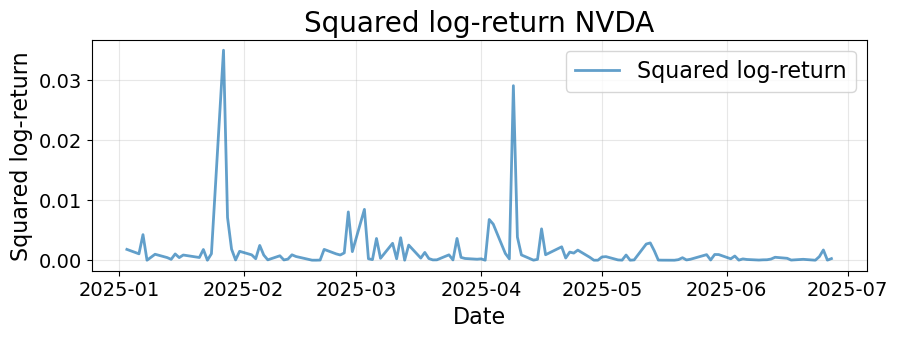

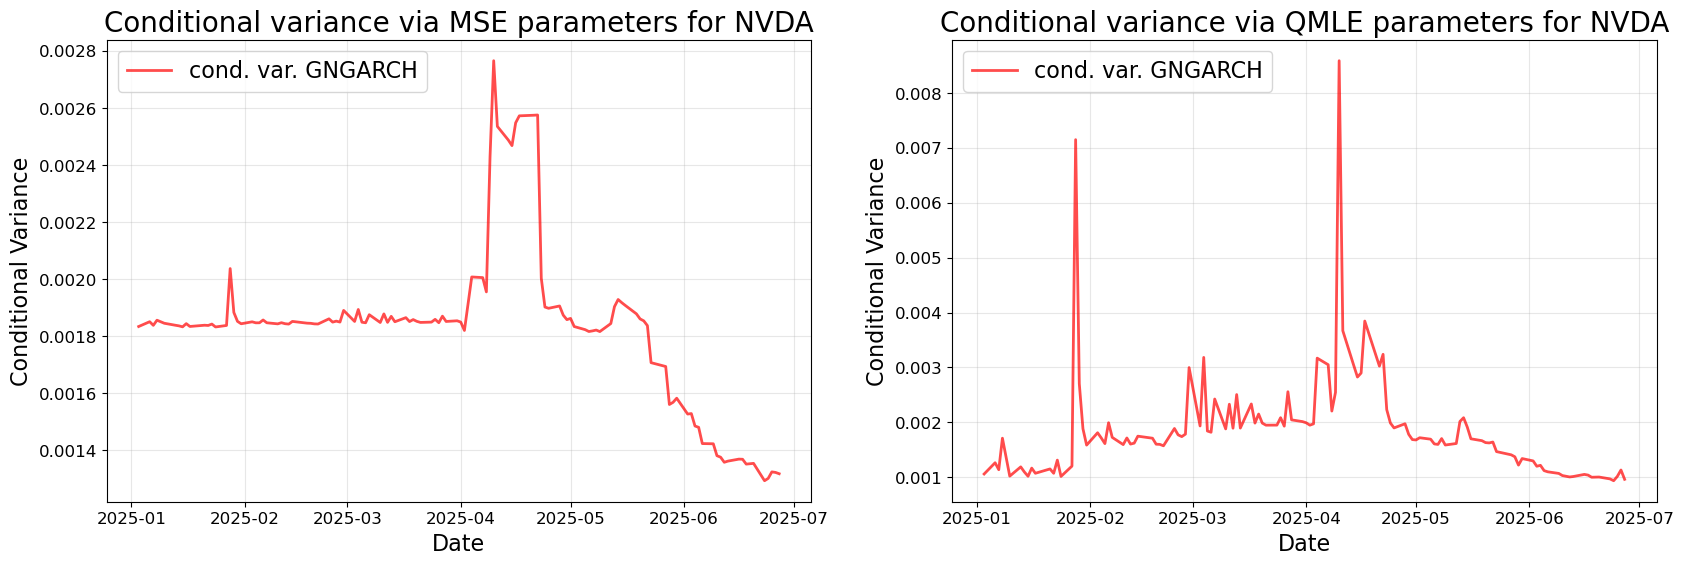

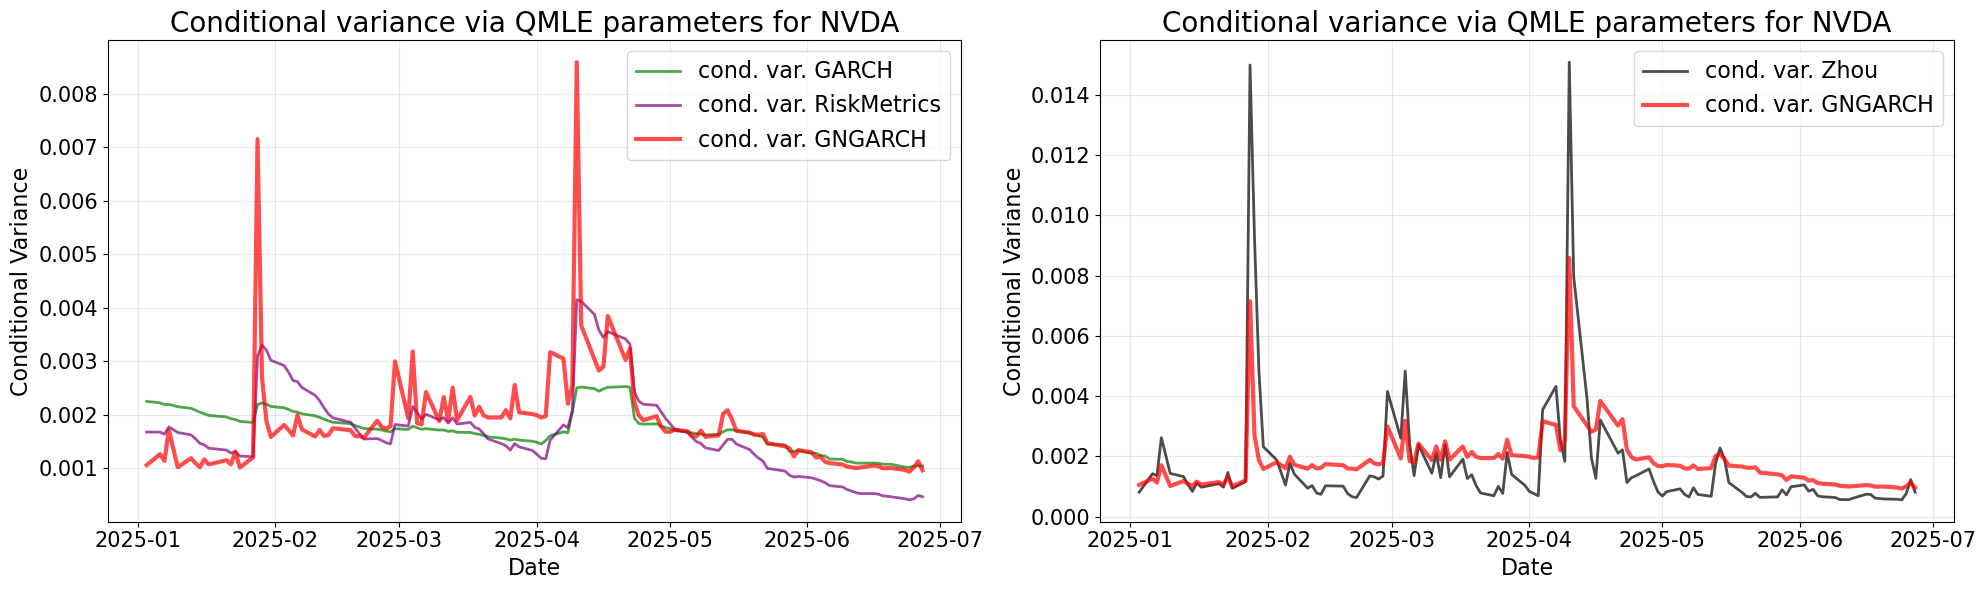

In [123]:
cond_var_forecast_mse_arr_Zhou = one_step_forecast_Zhou(log_returns, val_log_returns, params_mse_Zhou, window_size=60)
cond_var_forecast_nll_arr_Zhou = one_step_forecast_Zhou(log_returns, val_log_returns, params_nll_Zhou, window_size=60)

params_garch = cond_var_comparison_inst(val_log_returns, 'NVDA', 
                          cond_var_forecast_mse_arr, cond_var_forecast_nll_arr,
                          cond_var_forecast_mse_Zhou, cond_var_forecast_nll_Zhou, params_garch=params_garch, rescale_window=60)

In [132]:
def cond_cov_val_inst(df_val, stock_name1, stock_name2, 
                      cond_cov_mse_train, cond_cov_nll_train,
                      cond_cov_forecast_mse_val, cond_cov_forecast_nll_val, rescale_window=252):
    """
    Compare model conditional covariance (co-volatility) forecasts with the empirical cross-product of two stocks as proxy.

    Args:
        df_val (pd.DataFrame): validation daily log-return series, index = dates, columns = stock names.
        stock_name1 (str): name of the first stock (column in df).
        stock_name2 (str): name of the second stock (column in df).
        cond_cov_mse_train (pd.Series): the conditional covariance between selected stocks via MSE fit, as a known pd.Series.
        cond_cov_nll_train (pd.Series): the conditional covariance between selected stocks via QLIKE/NLL fit, as a known pd.Series.
        cond_cov_forecast_mse_val (np.ndarray): model forecasts from MSE fit on validation set, shape (T_val, d, d).
        cond_cov_forecast_nll_val (np.ndarray): model forecasts from QMLE/NLL fit on validation set, shape (T_val, d, d).
        rescale_window (int): window for dynamic rescaling, default 252.
    """

    if not isinstance(stock_name1, str) or not isinstance(stock_name2, str):
        raise ValueError("Stock names must be strings.")
    if stock_name1 not in df_val.columns or stock_name2 not in df_val.columns:
        raise KeyError("One or both stock names are not columns of `df`.")

    # Extract indices for stocks
    stock_idx1 = df_val.columns.get_loc(stock_name1)
    stock_idx2 = df_val.columns.get_loc(stock_name2)

    # Define dates and total T
    dates = df_val.index
    T = len(dates)

    # Extract the (i,j) co-volatility series over time
    cond_cov_mse_val = pd.Series(cond_cov_forecast_mse_val[:, stock_idx1, stock_idx2], index=dates)
    cond_cov_nll_val = pd.Series(cond_cov_forecast_nll_val[:, stock_idx1, stock_idx2], index=dates)

    # Empirical co-volatility proxy: cross-product of returns r_i * r_j (instantaneous)
    cross_prod = df_val[stock_name1] * df_val[stock_name2]

    # Dynamic rescale the model forecasts to align level with observed proxy (preserves dynamics)
    cond_cov_mse_val = dynamic_rescale(cond_cov_mse_val, cross_prod, rescale_window=rescale_window)
    cond_cov_nll_val = dynamic_rescale(cond_cov_nll_val, cross_prod, rescale_window=rescale_window)

    s = pd.concat([cond_cov_nll_train[-rescale_window-1:-1], cond_cov_nll_val])  # update s by concatenating the most recent rolling window value
    rolling_median = s.rolling(window=rescale_window).median()
    #rolling_median = rolling_median.replace([np.inf, -np.inf], np.nan).bfill()  # replace nan with the first valid median

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    axes[0].plot(dates, cross_prod, label=f'Cross product', alpha=0.7)
    axes[0].axhline(0, color='k', linewidth=1.5, label='zero baseline')
    axes[0].set_title(f'Cross log-return product between {stock_name1} and {stock_name2}', fontsize=20)
    axes[0].set_xlabel('Date', fontsize=16)
    axes[0].set_ylabel('Cross log-return product', fontsize=16)
    axes[0].tick_params(axis='both', which='major', labelsize=15)
    axes[0].legend(fontsize=16)
    axes[0].grid(alpha=0.3)

    axes[1].plot(dates, cond_cov_nll_val, label='cond. cov. GNGARCH', color='r', alpha=0.7)
    axes[1].plot(rolling_median.index, rolling_median, color='k', linewidth=1.5, label=f'{rescale_window}-day rolling median')
    axes[1].set_title(f'Conditional covariance via QMLE parameters between {stock_name1} and {stock_name2}', fontsize=20)
    axes[1].set_xlabel('Date', fontsize=16)
    axes[1].set_ylabel('Conditional covariance', fontsize=16)
    axes[1].tick_params(axis='both', which='major', labelsize=15)
    axes[1].legend(fontsize=16)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

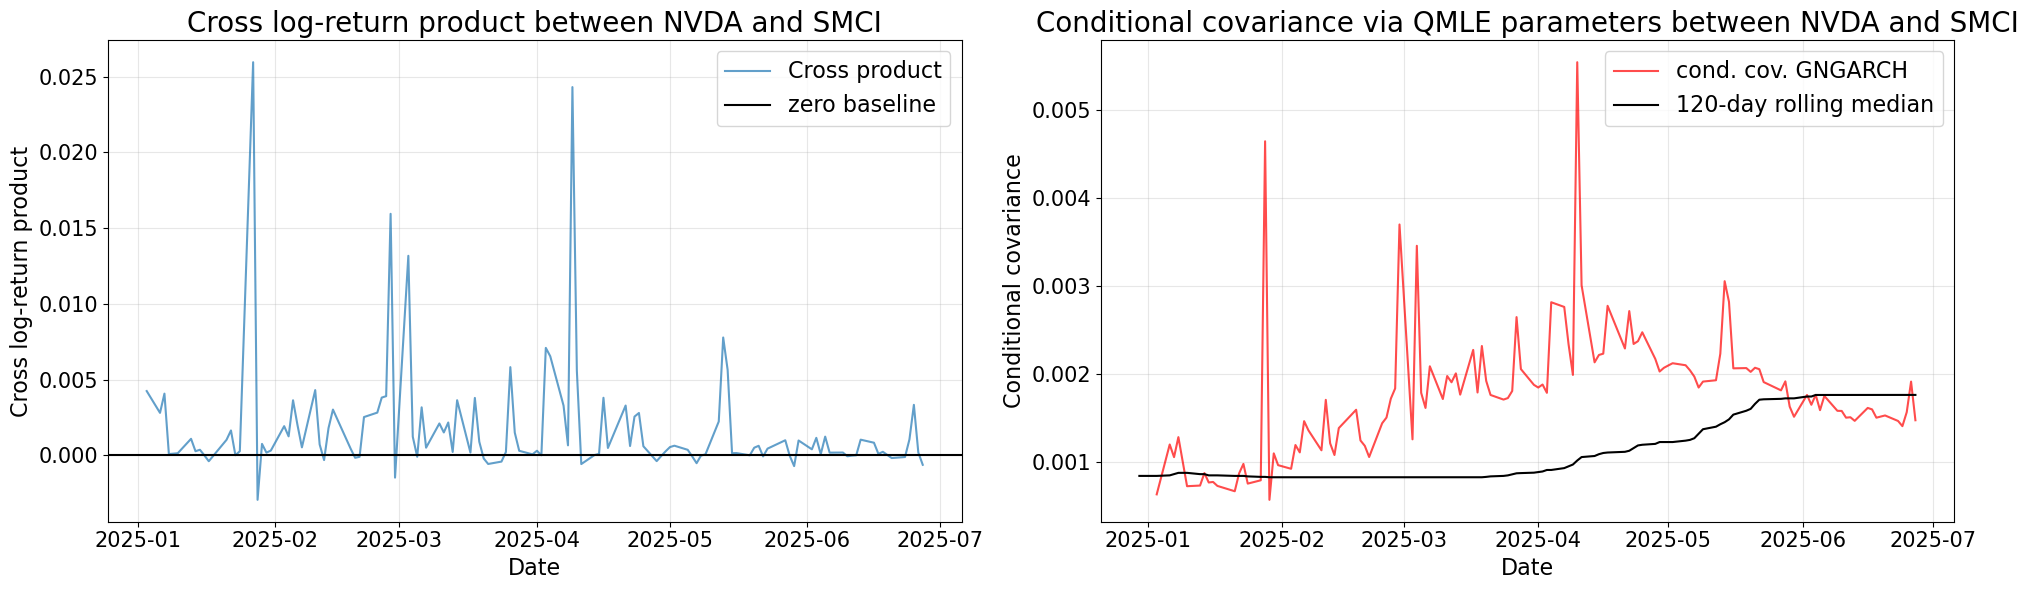

In [133]:
cond_cov_val_inst(val_log_returns, 'NVDA', 'SMCI', cond_cov_mse, cond_cov_nll,
                  cond_cov_forecast_mse_val=cond_cov_forecast_mse_arr,
                  cond_cov_forecast_nll_val=cond_cov_forecast_nll_arr,
                  rescale_window=120)